Breast Cancer Detection

# **1. Exploratory data analysis and preprocessing**

## **a. Import libraries**

In [2]:
#Import required libraries and explore file
# 📦 General-purpose libraries
import os
import re
import timm
import copy
import pickle
import random
import itertools
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from io import StringIO
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix,auc,roc_curve

# 🔥 PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 🧠 torchvision (models, transforms)
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms import functional as TF
from torchvision.transforms import RandAugment

from transformers import ViTForImageClassification,ViTImageProcessor

# 📊 Scikit-learn
from sklearn.model_selection import train_test_split

# 🧾 File explorer 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr0.0001_drop0.5_wd1e-05_weights.pth
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr1e-05_drop0.5_wd0.0001_weights.pth
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr1e-05_drop0.5_wd1e-05_metrics.pkl
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr1e-05_drop0.4_wd1e-05_metrics.pkl
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr0.0001_drop0.4_wd1e-05_metrics.pkl
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr0.0001_drop0.5_wd0.0001_weights.pth
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr1e-05_drop0.5_wd1e-05_weights.pth
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr1e-05_drop0.4_wd0.0001_weights.pth
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr0.0001_drop0.5_wd1e-05_metrics.pkl
/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/custom_cnn_lr0.0001_drop0.5_wd

## **b. Load image & Information**

In [4]:
# Load and explore the data
X = np.load('../input/lymphoma-subtype-classification-fl-vs-cll/X.npy') 
Y = np.load('../input/lymphoma-subtype-classification-fl-vs-cll/Y.npy')   

#print data information
print ("Shape/Information in X(images):",X.shape) # Expected: (num_images, height, width, channels)
print("Shape/Information of Y(labels):", Y.shape)  # Expected: (num_images,)

#Print detailed information of database
print("\nDetailed Information")
print("Total number of images:",len(X))
print("Total number of class:",len(np.unique(Y)))
print("Class labels used:",np.unique(Y))
print("Number of IDC negative Images:",np.sum(Y==0))
print("Number of IDC positive Images:",np.sum(Y==1))
print('Percentage of positive images: {:.2f}%'.format(100*np.mean(Y)))
print("Image ratio(Width, Height, Channels):",format(X[0].shape))

Shape/Information in X(images): (5547, 50, 50, 3)
Shape/Information of Y(labels): (5547,)

Detailed Information
Total number of images: 5547
Total number of class: 2
Class labels used: [0 1]
Number of IDC negative Images: 2759
Number of IDC positive Images: 2788
Percentage of positive images: 50.26%
Image ratio(Width, Height, Channels): (50, 50, 3)


Most of the information has been provided above, but highlighted information is stated here:
- Dataset is well-balanced, with 50.26% IDC-positive and IDC-negative samples, which supports balanced model accuracy (Wei & Dunbrack, 2013).
- Labels consists only 0 and 1, confirming that this is a binary classification problem.

## **c. Plot images**

IDC Negative (5 Samples)


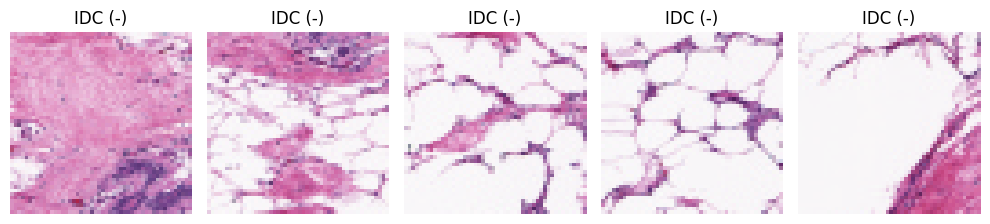

IDC Positive (5 Samples)


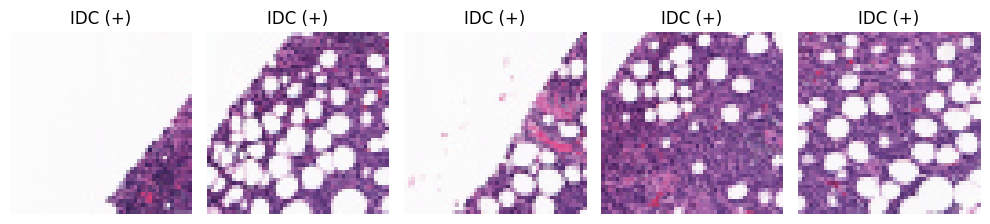

In [6]:
# Plot image for understanding before pre-processin
# Separate positive and negative images
IDC_neg = X[Y == 0]  # IDC Negative
IDC_pos = X[Y == 1]  # IDC Positive
img_count= 5 #Number of image

#Plot image for IDC Negative and Positive
def PlotImage(images, title):
    plt.figure(figsize=(10, 6))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
print("IDC Negative (5 Samples)")
PlotImage(IDC_neg[:img_count], 'IDC (-)')
print("IDC Positive (5 Samples)")
PlotImage(IDC_pos[:img_count], 'IDC (+)')



## **d. Distribution of pixel intensities**

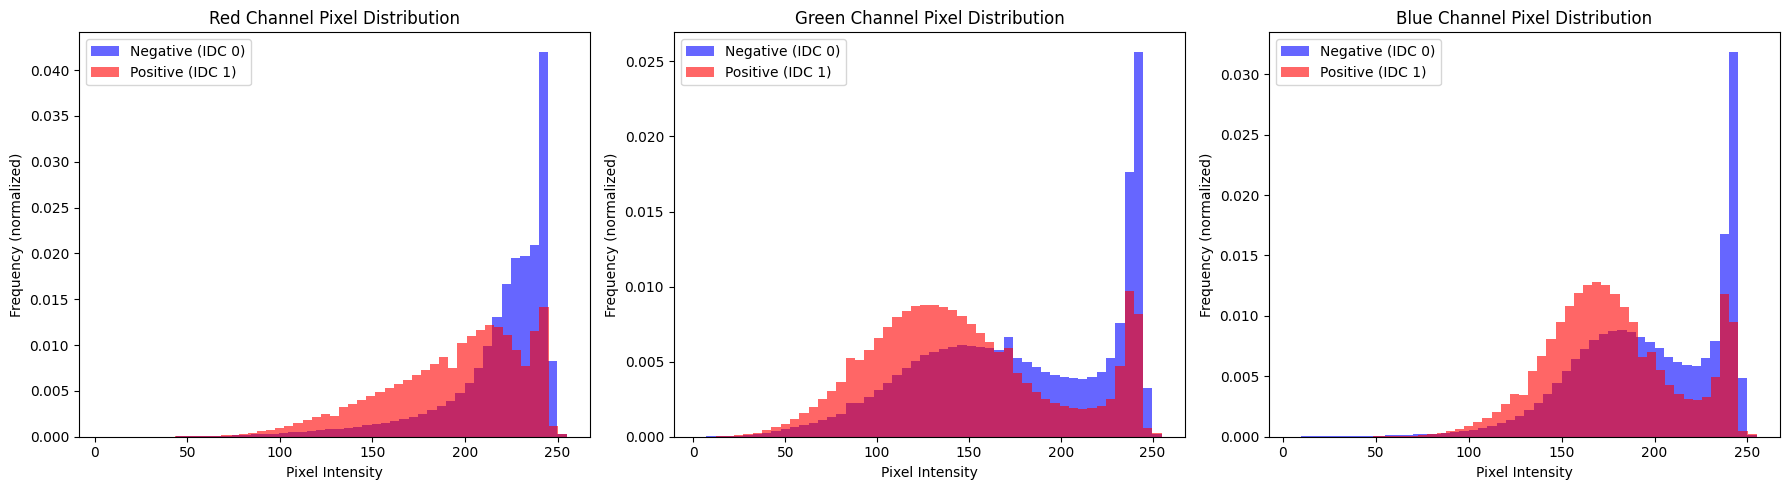

In [4]:
# Flatten pixel values for histogram
pixels_neg = IDC_neg.reshape(-1, X.shape[-1])  # Shape: (N_pixels, 3)
pixels_pos = IDC_pos.reshape(-1, X.shape[-1])

# Plot pixel distributions for each channel (R, G, B)
channels = ['Red', 'Green', 'Blue']
plt.figure(figsize=(18, 5))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(pixels_neg[:, i], bins=50, alpha=0.6, color='blue', label='Negative (IDC 0)', density=True)
    plt.hist(pixels_pos[:, i], bins=50, alpha=0.6, color='red', label='Positive (IDC 1)', density=True)
    plt.title(f'{channels[i]} Channel Pixel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency (normalized)')
    plt.legend()

plt.tight_layout()
plt.show()

The histogram displays normalized RGB pixel intensity distributions for IDC-negative and IDC-positive images, highlighting color intensity differences.

Key observations: \
    - Both classes show similar overall intensity patterns.\
    - IDC-negative images show more high-intensity pixels across all channels.\
    - IDC-positive images have more balanced intensities, slightly higher in Green and Blue.

These differences suggest pixel intensity aids model differentiation, being a key feature in image classification (Zheng & Sun, 2008).

## **e. Preprocessing steps**

### **1. Convert NPY format to PIL format**

In [7]:
#Converts the NPY data format into PIL image, for CNN
class IDCDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype('uint8')  # Convert to uint8
        label = self.labels[idx]
        
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Process images to suit archiecture requirement
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize
                         std=[0.229, 0.224, 0.225])
])

### **2. Augment and dataset for training**

In [8]:
#Augment the dataset.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### **3. Split data into train,validate,test**

In [10]:
# Step 1: Create full original dataset
full_dataset = IDCDataset(X, Y, transform=None)

# Step 2: Split into index sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Step 3: Split dataset into train, val and test
# Use fixed seed for reproducability
train_idx, val_idx, test_idx = random_split(
    range(total_size), [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Use normal datasets for val/test
train_dataset = Subset(IDCDataset(X, Y, transform=train_transforms), train_idx)
val_dataset = Subset(IDCDataset(X, Y, transform=transform), val_idx)
test_dataset = Subset(IDCDataset(X, Y, transform=transform), test_idx)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


The images is preprocessed for training deep learning models using these steps:
1. Convert image and label data into to PyTorch format.
2. Split data into train (80%), val (10%), and test (10%) with reproducible randomness.
3. Apply dynamic data augmentation (randAugment) to the training set to improve generalization and reduce overfitting (Yu et al., 2024).
5. Resize all images to 224x224 pixels and normalise data.

#### **3b. Check dataset information after preprocessing**

In [8]:
# Showcase data distribution of split dataset
def get_class_distribution(split_name, labels):
    total = len(labels)
    idc_neg = np.sum(labels == 0)
    idc_pos = np.sum(labels == 1)
    return {
        "Split": split_name,
        "IDC(-) Count": idc_neg,
        "IDC(+) Count": idc_pos,
        "Total": total,
        "IDC(-) %": round(idc_neg / total * 100, 2),
        "IDC(+) %": round(idc_pos / total * 100, 2)
    }
#Show class count focusing on training split:
train_labels = Y[train_idx]
val_labels = Y[val_idx]
test_labels = Y[test_idx]
# Collect distributions
data = [
    get_class_distribution("Train", train_labels),
    get_class_distribution("Validation", val_labels),
    get_class_distribution("Test", test_labels)
]

# Create DataFrame
distribution_df = pd.DataFrame(data)

# Display
print(f"Class distribution:")
print(distribution_df)

Class distribution:
        Split  IDC(-) Count  IDC(+) Count  Total  IDC(-) %  IDC(+) %
0       Train          2206          2231   4437     49.72     50.28
1  Validation           274           280    554     49.46     50.54
2        Test           279           277    556     50.18     49.82


Based on the table above, the training, validation, and test sets each show an approximately balanced distribution between IDC-negative and IDC-positive samples.

### **4. Show summary of Augmented dataset**

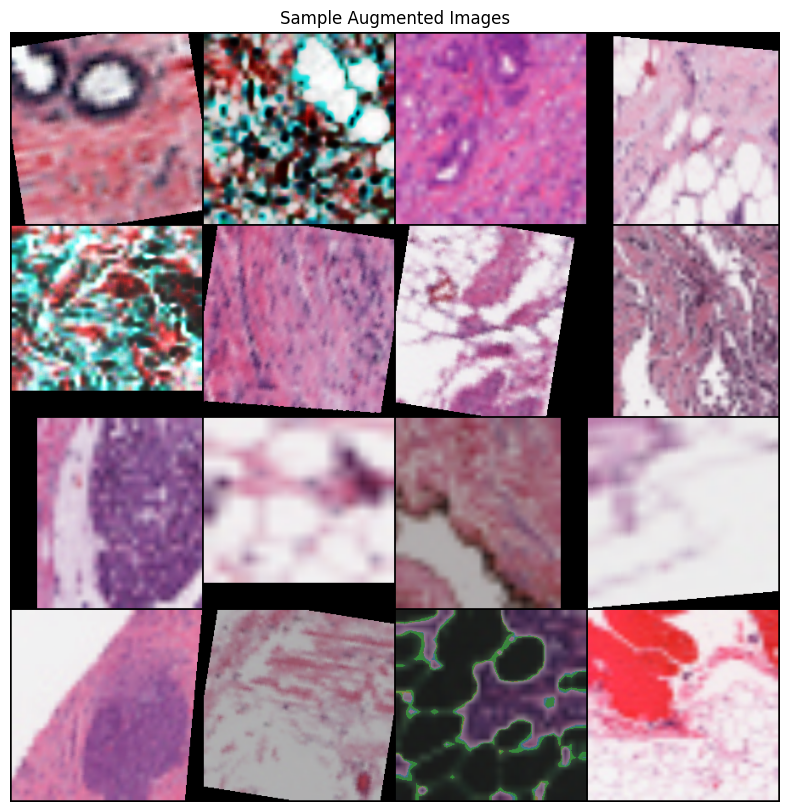

In [12]:
# show augmented data
def show_augmented_samples(data_loader):
    data_iter = iter(data_loader)
    images, _ = next(data_iter)

    unnorm_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    unnorm_images += torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    unnorm_images = torch.clamp(unnorm_images, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Sample Augmented Images")
    plt.imshow(vutils.make_grid(unnorm_images[:16], nrow=4).permute(1, 2, 0))
    plt.show()

# Inside your training loop
show_augmented_samples(train_loader)

# **2. Model design, training and fine-tuning**

All models (custom CNN, EfficientNet-B0, and Vision Transformer (ViT)) were trained under a consistent setup to ensure fair comparison and reproducibility:

1. Optimiser:
Adam optimizer was used across all models. Learning rates and weight decay values were adjusted during hyperparameter tuning.

2. Loss Function:
Binary Cross Entropy (BCE) loss was selected for binary classification.


4. Learning Rate Scheduler:
ReduceLROnPlateau reduced learning rate when validation loss plateaued.

5. Classifier Head:
All models shared a consistent custom classifier head, composed of:

    - Two hidden layers with ReLU activations and Linear transformations.

    - While the dimensions of the layers vary between models (due to different backbone outputs), the structure remains consistent.

6. Training Strategy:

    - The custom CNN was trained in a single-stage loop.

    - The pre-trained models (EfficientNet-B0 and ViT) followed a two-phase approach:
        1. Training only the classifier head (frozen backbone)

        2. Fine-tuning selected backbone layers
 
7. Hyperparameter Tuning: \
Each model was tuned using combinations of learning rate, dropout, and weight decay within a defined search space.

## **Common Code used for the models**

This section defines a reusable training pipeline to simplify model setup, training, fine-tuning, and evaluation across architectures.
Basic evaluation was included to track training, with detailed results shown in Section 3: Evaluation and Comparison.

### **a. Setup device**

In [37]:
#Setup data parallal and move device
def device_model_setup(model):
    if torch.cuda.device_count() > 1:
        print(f"🔀 Using {torch.cuda.device_count()} GPU")
        model = nn.DataParallel(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model, device

### **b. Training process**

The train_model function runs a complete training pipeline with optimizations for efficiency. \
Key steps include:
1. Training: \
Each epoch processes augmented batches, updating weights via backpropagation.
2. Validation: \
For each epoch, the model is evaluated using validation data. This is important to access generalisation of the model
4. Checkpointing:  \
If the validation loss improves, the model's weights are saved. This is to ensure that if subsequent training obtain worse performance,training can continue from the best-known state.
5. LR Scheduling: \
Reduces learning rate if validation loss plateaus to aid convergence.
6. Early Stopping: \
Training is implemented with early stopping mechanism,to reduce unecessary computation and preventing overfitting.
7. Logging: \
Training and validation loss and accuracy are recorded for each epoch.

In [12]:
# Training loop, with early stopping and learning rate scheduling
def train_model(model, device, train_loader, val_loader, test_loader,
                     criterion, optimizer, scheduler,
                     checkpoint_path,
                     num_epochs=3, phase="phase_1", early_stopping_patience=5):

    # Load previous weights if fine-tuning (phase_2)
    if phase == "phase_1":
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Loaded weights from {checkpoint_path}")

    # Logging training informations
    phase_train_loss = []
    phase_val_loss = []
    phase_val_acc = []

    # Early stopping trackers
    best_val_loss = float('inf')
    patience_counter = 0

    print(f"Start training ({phase})...")

    # Loop for epoch training
    for epoch in range(num_epochs):
        #Initialise model training mode
        model.train()
        total_train_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            # Handle Hugging Face models that output a wrapper object
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            
            # Compute loss
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Handle Hugging Face models that output a wrapper object
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
                    
                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Log data
        phase_train_loss.append(avg_train_loss)
        phase_val_loss.append(avg_val_loss)
        phase_val_acc.append(val_accuracy)

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Save best model weights if validation loss improves
        is_best = False
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, checkpoint_path)
            patience_counter = 0
            is_best = True
        else:
            patience_counter += 1
    
        # Print epoch info every 5 epochs or if best model
        if (epoch + 1) % 5 == 0 or epoch == 0 or (epoch + 1) == num_epochs or is_best:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | "
                  f"Val Acc: {val_accuracy:.2f}%")
            
            if is_best:
                print("✅ Best model weights saved.")
    
        # Early stopping if multiple runs without improvement
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {patience_counter} epochs without improvement.")
            break

    # Save and return log
    log_data = {
        f"{phase}_train_loss": phase_train_loss,
        f"{phase}_val_loss": phase_val_loss,
        f"{phase}_val_acc": phase_val_acc
    }

    return log_data


### **c. Training and Fine-tuning process**

The fine_tune_model function applies transfer learning to pre-trained models using a custom classifier and hyperparameter tuning. \
Steps:
1. Top-Tuning (Classifier Training): \
Pretrained model is initialised with custom classifier head. All backbone layers are frozen, and only the classifier is trained on the dataset.
2. Fine-tuning: \
Unfreeze selected backbone layers. Fine-tuning is performed using a reduced optimizer learning rate and scheduler settings, improving performance while minimizing overfitting.
3. Evaluation: \
Test the final model to assess accuracy and generalization.
4. Logging: \
All training and validation metrics for each run, along with the hyperparameters used is saved into a file.

In [12]:
# Fine-tune pre-trained model using hyperparameter search
def fine_tune_model(
    title,
    model_builder_func,
    unfreeze_func,
    learning_rates,
    dropout_rates,
    weight_decays,
    train_loader,
    val_loader,
    test_loader,
    device_model_setup,
    early_stopping_patience_phase1=7,
    early_stopping_patience_phase2=5,
    num_epochs_phase1=100,
    num_epochs_phase2=70
):
    #Loop through search space hyperparameter
    for lr, dr, wd in itertools.product(learning_rates, dropout_rates, weight_decays):
        print(f"\n🔧 Tuning: lr={lr}, dropout={dr}, weight_decay={wd}")

        # Step 1: Create, build and setup model for each run
        base_model = model_builder_func()
        model, device = device_model_setup(base_model)

        # Step 2: Setup optimizer, scheduler, loss function
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

        # Setup filenames for fine-tuned weights
        current_title = f"{title}_lr{lr}_drop{dr}_wd{wd}"
        checkpoint_path = f"{current_title}_weights.pth"

        # Step 2: Phase 1 Training -Train classifier head
        log_data_phase1 = train_model(
            model=model,
            device=device,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            checkpoint_path=checkpoint_path,
            num_epochs=num_epochs_phase1,
            phase="phase_1",
            early_stopping_patience=early_stopping_patience_phase1
        )

        # Step 4: Unfreeze backbone layers for fine-tuning
        unfreeze_func(model)

        # Step 5: Setup new optimizer/scheduler for fine-tuning
        optimizer_finetune = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                        lr=lr/10, weight_decay=wd)
        scheduler_finetune = ReduceLROnPlateau(optimizer_finetune, mode='min', factor=0.2, patience=3, min_lr=1e-6)

        # Step 6: Phase 2 Fine-tuning
        log_data_phase2 = train_model(
            model=model,
            device=device,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer_finetune,
            scheduler=scheduler_finetune,
            checkpoint_path=checkpoint_path,
            num_epochs=num_epochs_phase2,
            phase="phase_2",
            early_stopping_patience=early_stopping_patience_phase2
        )

        # Step 7: Simple final evaluation
        final_accuracy = evaluate_final_model(
            model=model,
            test_loader=test_loader,
            checkpoint_path=checkpoint_path,
            device=device,
            phase_name="Fine-Tuned"
        )

        print(f"📊 Final Test Accuracy for {title}: {final_accuracy:.2f}%")

        # Save logs
        final_log = {
            "phase_1": log_data_phase1,
            "phase_2": log_data_phase2,
            "final_accuracy": final_accuracy,
            "hyperparams": {
                "lr": lr,
                "dropout": dr,
                "weight_decay": wd
            }
        }

        with open(f"{current_title}_metrics.pkl", "wb") as f:
            pickle.dump(final_log, f)


### **d. Simple test result**

In [13]:
# Load trained model from checkpoint and evaluate accuracy on test dataset
# This is just a simple test, to provide a simple understanding of the fine-tuned models
# A more complicated test is presented at the evaluation and comparism session
def evaluate_final_model(model, test_loader, checkpoint_path, device, phase_name="Final"):

    # Load trained weights
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    model.to(device)
    model.eval()

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)

            # 🛡️ Fix: If outputs is object (like ViT), grab logits
            if hasattr(outputs, "logits"):
                outputs = outputs.logits

            preds = (torch.sigmoid(outputs) > 0.5).float()
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    accuracy = 100 * test_correct / test_total
    print(f"🧪 {phase_name} Test Accuracy: {accuracy:.2f}%")
    return accuracy


## **a. Custom CNN**

A custom Convolutional Neural Network (CNN) is used for binary classification, chosen for its effectiveness in image tasks and simplicity (O’Shea & Nash, 2015).

This section showcases a custom Convolutional Neural Network (CNN), designed for binary classification tasks.\
Key Features:
1. Convolutional Blocks: \
Composed of four sequential block, each with a convolutional layer consists of ReLU activation, max pooling and dropout. The convolutional layers and dropout rate increase progressively in deeper layer to improve regularisation, greater accuracy while avoiding overfitting.
2. Global Averge Pooling: \
Reduces spatial dimensions, enhancing translation invariance and preventing overfitting (Lin et al., 2013).


### **a. Modular CNN block**

In [17]:
# Define the building block of the model
# This is a simple CNN block with convolution, ReLU activation, max pooling, and dropout
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,padding=1,dropout=0.25):
        super(CNNBlock,self).__init__()
        self.convolution = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)     
        self.dropout = nn.Dropout2d(dropout)  

    
    def forward(self,x):
        x=self.convolution(x)
        x=self.relu(x)
        x=self.pool(x)
        x=self.dropout(x)
        return x

In [18]:
# Define the main model class
# Simple CNN model with four convolutional blocks, global pooling, and fully connected layers
class ConvNeuralNetwork(nn.Module):
    def __init__(self, in_channels, conv_channels, kernel_size, padding, dropout_conv, dropout_fc, num_classes=1):
        super(ConvNeuralNetwork, self).__init__()

        self.conv_blocks = nn.Sequential(
            CNNBlock(in_channels, conv_channels[0], kernel_size, padding, dropout_conv[0]),
            CNNBlock(conv_channels[0], conv_channels[1], kernel_size, padding, dropout_conv[1]),
            CNNBlock(conv_channels[1], conv_channels[2], kernel_size, padding, dropout_conv[2]),
            CNNBlock(conv_channels[2], conv_channels[3], kernel_size, padding, dropout_conv[3])
        )

        # Global pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B, 128, H, W] -> [B, 128, 1, 1]

        #Define connected neural network layer
        self.CNNL =nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_channels[3],128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_fc),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_fc),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = self.conv_blocks(x)
        x = self.global_pool(x)
        
        # Pass the flattened features through the fully connected layers
        x = self.CNNL(x)
        return x


### **b.Initialisation and summary of custom CNN**

In [19]:
# Parameter for CNN
model_config = {
    "in_channels": 3,
    "conv_channels": [32, 64, 128,256],
    "kernel_size": 3,
    "padding": 1,
    "dropout_conv": [0.2, 0.3, 0.4, 0.5],
    "dropout_fc": 0.5,
    "num_classes": 1
}
def build_cnn_model():
    return ConvNeuralNetwork(**model_config)

# build model
CNN_model = build_cnn_model()

# Example for input image of size (3, 224, 224)
summary(CNN_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNeuralNetwork                        [1, 1]                    --
├─Sequential: 1-1                        [1, 256, 14, 14]          --
│    └─CNNBlock: 2-1                     [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 224, 224]         896
│    │    └─ReLU: 3-2                    [1, 32, 224, 224]         --
│    │    └─MaxPool2d: 3-3               [1, 32, 112, 112]         --
│    │    └─Dropout2d: 3-4               [1, 32, 112, 112]         --
│    └─CNNBlock: 2-2                     [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 112, 112]         18,496
│    │    └─ReLU: 3-6                    [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-7               [1, 64, 56, 56]           --
│    │    └─Dropout2d: 3-8               [1, 64, 56, 56]           --
│    └─CNNBlock: 2-3                     [1, 128, 28, 28]          --
│    │    

### **b. Hyperparameter tuning**

The custom CNN was trained from scratch using a single-phase training loop with hyperparameter tuning. \
Key steps:
1. Define search ranges for learning rate, dropout, and weight decay.
2. Re-initialize and retrain the model for each combination.
3. Evaluate on the test set and save accuracy, training metrics, and hyperparameters to .pkl files for analysis.

In [18]:
# Search space
learning_rates = [1e-4, 1e-5]
dropout_rates = [0.4, 0.5]
weight_decays = [1e-4, 1e-5]

early_stopping_patience = 7
num_epochs = 100

# Loop through combinations
for lr, dr, wd in itertools.product(learning_rates, dropout_rates, weight_decays):
    print(f"\n🔧 Tuning: lr={lr}, dropout={dr}, weight_decay={wd}")

    # Create new CNN model each loop
    CNN_model = ConvNeuralNetwork(**model_config)

    # Setup model and device
    model, device = device_model_setup(CNN_model)

    # Optimizer, scheduler
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

    # Paths
    title = f"custom_cnn_lr{lr}_drop{dr}_wd{wd}"
    checkpoint_path = f"{title}_weights.pth"

    ### Single Phase Training ###
    log_data = train_model(
        model=model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        checkpoint_path=checkpoint_path,
        num_epochs=num_epochs,
        phase="phase_1",
        early_stopping_patience=early_stopping_patience
    )

    # Final test accuracy
    final_accuracy = evaluate_final_model(
        model=model,
        test_loader=test_loader,
        checkpoint_path=checkpoint_path,
        device=device,
        phase_name="Final"
    )

    print(f"📊 Final Test Accuracy for {title}: {final_accuracy:.2f}%")

    ### Save logs ###
    final_log = {
        "log_data": log_data,
        "final_accuracy": final_accuracy,
        "hyperparams": {
            "lr": lr,
            "dropout": dr,
            "weight_decay": wd
        }
    }

    with open(f"{title}_metrics.pkl", "wb") as f:
        pickle.dump(final_log, f)



🔧 Tuning: lr=1e-05, dropout=0.5, weight_decay=0.0001
🔀 Using 2 GPUs via DataParallel
🚀 Start training (phase_1)...
Epoch 1/100 | Train Loss: 0.6943 | Val Loss: 0.6951 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 2/100 | Train Loss: 0.6942 | Val Loss: 0.6949 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 3/100 | Train Loss: 0.6942 | Val Loss: 0.6946 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 4/100 | Train Loss: 0.6935 | Val Loss: 0.6942 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 5/100 | Train Loss: 0.6937 | Val Loss: 0.6938 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 6/100 | Train Loss: 0.6931 | Val Loss: 0.6932 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 7/100 | Train Loss: 0.6927 | Val Loss: 0.6923 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 8/100 | Train Loss: 0.6924 | Val Loss: 0.6911 | Val Acc: 49.46%
✅ Best model weights saved.
Epoch 9/100 | Train Loss: 0.6918 | Val Loss: 0.6893 | Val Acc: 50.54%
✅ Best model weights saved.
Ep

## **b. Efficientnet**

This section presents a pre-trained EfficientNet-B0, a lightweight Convolutional Neural Network (CNN)(Tan and Le, 2019). The base model was adapted by replacing its original classifier with a custom head suitable for binary classification.

Key Features: \
Efficient Feature Extraction: \
Uses Mobile Inverted Bottleneck (MBConv) blocks with squeeze-and-excitation modules to capture rich, low-cost feature representations.

Fine-Tuning Strategy: \
Final backbone blocks (features.6 and features.7) were unfrozen during fine-tuning, allowing task adaptation while retaining pretrained knowledge.

### **a. Initialization with Custom Binary Classifier head**

In [20]:
# Function to load efficientnet with default weight, and freeze the base
def build_efficientnet():
    #Load pretrained model
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    
    #Freeze backbone
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace and use the classifier head with additional layers
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier[1].in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1)
    )
    return model

#Unfreeze efficientnet parameter for fine-tuning
def unfreeze_efficientnet(model):
    for name, param in model.named_parameters():
        if "features.6" in name or "features.7" in name:
            param.requires_grad = True

# Build the model
efficientnet_model = build_efficientnet()

#Show Architecture
print("Architecture of Efficientnet model")
summary(efficientnet_model, input_size=(32, 3, 224, 224))

Architecture of Efficientnet model


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1]                   --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

### **b. Hyperparameter tuning**

In [15]:
# Define the search space
learning_rates = [1e-4, 1e-5]
dropout_rates = [0.4, 0.5]
weight_decays = [1e-4, 1e-5]

# Patience parameter and number of epoches for training model
early_stopping_patience_phase1 = 7
early_stopping_patience_phase2 = 5
num_epochs_phase1 = 100
num_epochs_phase2 = 70

# Explaination has been done previously when the function is introduced
fine_tune_model(
    title="efficientnet",
    model_builder_func=build_efficientnet,
    unfreeze_func=unfreeze_efficientnet,
    learning_rates=learning_rates,
    dropout_rates=dropout_rates,
    weight_decays=weight_decays,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device_model_setup=device_model_setup,
    early_stopping_patience_phase1=early_stopping_patience_phase1,
    early_stopping_patience_phase2=early_stopping_patience_phase2,
    num_epochs_phase1=num_epochs_phase1,
    num_epochs_phase2=num_epochs_phase2
)


🔧 Tuning: lr=1e-05, dropout=0.4, weight_decay=0.0001
🔀 Using 2 GPUs via DataParallel
🚀 Start training (phase_1)...
Epoch 1/100 | Train Loss: 0.6922 | Val Loss: 0.6913 | Val Acc: 56.50%
✅ Best model weights saved.
Epoch 2/100 | Train Loss: 0.6897 | Val Loss: 0.6883 | Val Acc: 66.97%
✅ Best model weights saved.
Epoch 3/100 | Train Loss: 0.6877 | Val Loss: 0.6850 | Val Acc: 69.86%
✅ Best model weights saved.
Epoch 4/100 | Train Loss: 0.6840 | Val Loss: 0.6812 | Val Acc: 68.77%
✅ Best model weights saved.
Epoch 5/100 | Train Loss: 0.6807 | Val Loss: 0.6759 | Val Acc: 70.94%
✅ Best model weights saved.
Epoch 6/100 | Train Loss: 0.6763 | Val Loss: 0.6690 | Val Acc: 72.02%
✅ Best model weights saved.
Epoch 7/100 | Train Loss: 0.6700 | Val Loss: 0.6612 | Val Acc: 71.66%
✅ Best model weights saved.
Epoch 8/100 | Train Loss: 0.6652 | Val Loss: 0.6533 | Val Acc: 73.47%
✅ Best model weights saved.
Epoch 9/100 | Train Loss: 0.6591 | Val Loss: 0.6466 | Val Acc: 71.48%
✅ Best model weights saved.
Ep

/tmp/ipykernel_31/1076554286.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Epoch 1/70 | Train Loss: 0.5909 | Val Loss: 0.5248 | Val Acc: 77.98%
✅ Best model weights saved.
Epoch 2/70 | Train Loss: 0.5847 | Val Loss: 0.5187 | Val Acc: 77.62%
✅ Best model weights saved.
Epoch 3/70 | Train Loss: 0.5776 | Val Loss: 0.5116 | Val Acc: 78.52%
✅ Best model weights saved.
Epoch 5/70 | Train Loss: 0.5792 | Val Loss: 0.5283 | Val Acc: 76.17%
Epoch 6/70 | Train Loss: 0.5855 | Val Loss: 0.5055 | Val Acc: 78.34%
✅ Best model weights saved.
Epoch 10/70 | Train Loss: 0.5795 | Val Loss: 0.5052 | Val Acc: 78.70%
✅ Best model weights saved.
Epoch 12/70 | Train Loss: 0.5671 | Val Loss: 0.5023 | Val Acc: 77.26%
✅ Best model weights saved.
Epoch 15/70 | Train Loss: 0.5767 | Val Loss: 0.5237 | Val Acc: 75.99%
⛔ Early stopping triggered after 5 epochs without improvement.
🧪 Fine-Tuned Test Accuracy: 79.68%
📊 Final Test Accuracy for efficientnet_lr1e-05_drop0.4_wd0.0001: 79.68%

🔧 Tuning: lr=1e-05, dropout=0.4, weight_decay=1e-05
🔀 Using 2 GPUs via DataParallel
🚀 Start training (phas

## **c. ViT**

This section introduces Vision Transformer(ViT), a pre-trained model that utilises Transformer architecture for image classification. The specific model used is vit-base-patch16-224, pretrained by Google.\
Key Features: 
1. Patch-Based Input: \
Images are split into fixed-size patches, embedded as vectors, and processed as sequences—capturing global spatial relationships from the start.
2. Self-attention mechanism: \
Instead of convolutions, ViT uses multi-head self-attention to model relationships between all patches simultaneously.
3. High Data Requirement: \
Unlike typical CNN, ViT typically require large amount of training data to achieve optimal performance. To mitigate this, random augmentations were applied dynamically during training, introducing greater data diversity and improve generalisation.


### **a. Initialization with Custom Binary Classifier head**

In [22]:
#Function to load pretrained ViT
def build_vit():
    # Load model
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

    #Freeze backbone
    for param in model.vit.parameters():
        param.requires_grad = False

    #Add random classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1)
    )
    return model

#Function to unfreeze parameter for fine-tuning
def unfreeze_vit(model):
    for name, param in model.named_parameters():
        if "vit.encoder.layer.10" in name or "vit.encoder.layer.11" in name:
            param.requires_grad = True

#load ViT model
vit_model=build_vit()

# Check model Architecture summary
summary(vit_model, input_size=(32, 3, 224, 224))


Layer (type:depth-idx)                                  Output Shape              Param #
ViTForImageClassification                               [32, 1]                   --
├─ViTModel: 1-1                                         [32, 197, 768]            --
│    └─ViTEmbeddings: 2-1                               [32, 197, 768]            152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [32, 196, 768]            (590,592)
│    │    └─Dropout: 3-2                                [32, 197, 768]            --
│    └─ViTEncoder: 2-2                                  [32, 197, 768]            --
│    │    └─ModuleList: 3-3                             --                        (85,054,464)
│    └─LayerNorm: 2-3                                   [32, 197, 768]            (1,536)
├─Sequential: 1-2                                       [32, 1]                   --
│    └─Dropout: 2-4                                     [32, 768]                 --
│    └─Linear: 2-5               

In [15]:
# Define the search space
learning_rates = [1e-3,1e-4]
dropout_rates = [0.4, 0.5]
weight_decays = [1e-4, 1e-5]

# Patience parameter and number of epoches for training model
early_stopping_patience_phase1 = 7
early_stopping_patience_phase2 = 5
num_epochs_phase1 = 100
num_epochs_phase2 = 70

# Explaination has been done previously when the function is introduced
fine_tune_model(
    title="ViT",
    model_builder_func=build_vit,
    unfreeze_func=unfreeze_vit,
    learning_rates=learning_rates,
    dropout_rates=dropout_rates,
    weight_decays=weight_decays,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device_model_setup=device_model_setup,
    early_stopping_patience_phase1=early_stopping_patience_phase1,
    early_stopping_patience_phase2=early_stopping_patience_phase2,
    num_epochs_phase1=num_epochs_phase1,
    num_epochs_phase2=num_epochs_phase2
)


🔧 Tuning: lr=0.001, dropout=0.4, weight_decay=0.0001
🔀 Using 2 GPUs via DataParallel
Start training (phase_1)...
Epoch 1/100 | Train Loss: 0.6004 | Val Loss: 0.5393 | Val Acc: 73.47%
Best model weights saved.
Epoch 2/100 | Train Loss: 0.5676 | Val Loss: 0.4758 | Val Acc: 77.98%
Best model weights saved.
Epoch 5/100 | Train Loss: 0.5528 | Val Loss: 0.5040 | Val Acc: 75.99%
Epoch 6/100 | Train Loss: 0.5483 | Val Loss: 0.4662 | Val Acc: 78.88%
Best model weights saved.
Epoch 10/100 | Train Loss: 0.5344 | Val Loss: 0.4821 | Val Acc: 77.26%
Epoch 11/100 | Train Loss: 0.5291 | Val Loss: 0.4570 | Val Acc: 79.42%
Best model weights saved.
Epoch 14/100 | Train Loss: 0.5182 | Val Loss: 0.4567 | Val Acc: 79.24%
Best model weights saved.
Epoch 15/100 | Train Loss: 0.5189 | Val Loss: 0.4750 | Val Acc: 77.44%
Epoch 16/100 | Train Loss: 0.5116 | Val Loss: 0.4563 | Val Acc: 80.32%
Best model weights saved.
Epoch 19/100 | Train Loss: 0.5262 | Val Loss: 0.4526 | Val Acc: 81.23%
Best model weights saved

/tmp/ipykernel_32/1429622605.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Epoch 1/70 | Train Loss: 0.5211 | Val Loss: 0.4562 | Val Acc: 79.60%
Best model weights saved.
Epoch 2/70 | Train Loss: 0.5097 | Val Loss: 0.4457 | Val Acc: 79.78%
Best model weights saved.
Epoch 3/70 | Train Loss: 0.5009 | Val Loss: 0.4250 | Val Acc: 82.31%
Best model weights saved.
Epoch 5/70 | Train Loss: 0.4950 | Val Loss: 0.4643 | Val Acc: 78.34%
Early stopping triggered after 5 epochs without improvement.
🧪 Fine-Tuned Test Accuracy: 80.76%
📊 Final Test Accuracy for ViT: 80.76%

🔧 Tuning: lr=0.001, dropout=0.4, weight_decay=1e-05
🔀 Using 2 GPUs via DataParallel
Start training (phase_1)...
Epoch 1/100 | Train Loss: 0.5871 | Val Loss: 0.5344 | Val Acc: 72.74%
Best model weights saved.
Epoch 2/100 | Train Loss: 0.5583 | Val Loss: 0.4979 | Val Acc: 77.08%
Best model weights saved.
Epoch 3/100 | Train Loss: 0.5592 | Val Loss: 0.4626 | Val Acc: 78.88%
Best model weights saved.
Epoch 5/100 | Train Loss: 0.5512 | Val Loss: 0.4908 | Val Acc: 77.44%
Epoch 6/100 | Train Loss: 0.5308 | Val Lo

# **3. Evaluation and Comparison**

For the evaluation phase, the analysis is divided into the following segments:
1. Hyperparameter Overview: \
All models will be presented with their hyperparameters, final test accuracy, and (for fine-tuned models) Phase 2 final validation accuracy.
2. Top-3 Shortlisting and Visualisation: \
For each model type, the top three runs (based on final test accuracy) are shortlisted. These models will be analyzed using training and evaluation metrics to identify the best performer within each class.
3. Best Model Selection : \
The best model from each category will be compared using multiple evaluation metrics to determine the overall top-performing model.

Evaluation Metrics Used:
1. Accuracy: \
Measures the percentage of correct predictions.
2. Classification: \
Utilise detailed metrics including precision, recall, F1-score and support.
3. Confusion matrix: \
Summarizes true positives, true negatives, false positives, and false negatives for a detailed view of prediction outcomes.
4. Receiver Operating Characteristic (ROC) Curve and Area Under the Curve (AUC) Score: \
The ROC curve plots True Positive Rate(TPR) vs. False Positive Rate (FPR) across thresholds.AUC measures class separation, where higher is better

## **Common code used for evaluation**

### **a. Helper Function**

In [ ]:
# Extract model name based on filename
def extract_model_name(filename):
    match = re.search(r"^(.*?)_lr", filename)
    return match.group(1) if match else "Unknown"

# Extract random color
def get_random_color():
    """Returns a truly random hex color code."""
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

# Helper for denormalization 
# Used for image clarity
def denormalise(img_tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

def load_trained_model(model_builder_func, device_model_setup, weight_directory, weight_filename):
    weight_path = os.path.join(weight_directory, weight_filename.replace("_metrics.pkl", "_weights.pth"))
    model = model_builder_func()
    model, device = device_model_setup(model)
    model.load_state_dict(torch.load(weight_path, map_location=device, weights_only=True))
    model.to(device)
    return model, device



### **b. Remaining Function**

Separate functions were created to extract and display specific metrics, but no individual headers were assigned. Instead, all explanations are provided through inline comments.

In [23]:
#Load directory of each model weight file from directory
def load_file_from_directory(directory_path):

    # Store the metric list
    metrics_list = []

    #Loop through the list, search for pkl files then load it into the list
    for filename in os.listdir(directory_path):
        if filename.endswith(".pkl"):
            full_path = os.path.join(directory_path, filename)
            with open(full_path, "rb") as f:
                files = pickle.load(f)
                files["filename"] = filename  # attach filename for tracking
                metrics_list.append(files)    # append into list

    return metrics_list


In [24]:
# Generate pandas dataframe with Model, Learning Rate,Dropout,Weight Decay, Final Accuracy,Last Val Acc (Phase1 or Phase 2)
def parse_metrics_to_dataframe(metrics_list):
    
    results = []

    # Step 1: Open File
    for m in metrics_list:
        filename = m.get("filename", "")

        model_name = extract_model_name(filename)

        # Step 2: Extract hyperparameters (lr, dropout, weight decay)
        match = re.search(r"lr([\d.e-]+)_drop([\d.e-]+)_wd([\d.e-]+)", filename)
        if match:
            lr = float(match.group(1))
            drop = float(match.group(2))
            wd = float(match.group(3))
        else:
            lr = drop = wd = None

        # Step 3: Extract final accuracy from metrics
        final_acc = m.get("final_accuracy", None)

        # Step 4: Build dictionary record for each model entry
        record = {
            "Model": model_name,
            "Learning Rate": lr,
            "Dropout": drop,
            "Weight Decay": wd,
            "Final Accuracy": final_acc,
            "Filename": filename 
        }

        # Step 5: Retrieve the last validation accuracy from phase_2 (if available) or phase_1
        if "phase_2" in m:
            record["Last Val Acc (Phase2)"] = m.get("phase_2", {}).get("phase_2_val_acc", [-1])[-1]
        elif "log_data" in m:
            record["Last Val Acc (Phase1)"] = m.get("log_data", {}).get("phase_1_val_acc", [-1])[-1]

        results.append(record)
        
    # Step 6: Convert the collected records into a pandas DataFrame
    df_results = pd.DataFrame(results)
    
    # Step 7: Sort the DataFrame by Final Accuracy (descending) and reset index
    df_results = df_results.sort_values(by="Final Accuracy", ascending=False).reset_index(drop=True)
    df_results.index = df_results.index + 1  # 1-based indexing for readability

    # Step 8: Store filenames separately and drop from display DataFrame
    reordered_filenames = df_results["Filename"].tolist()
    df_results_clean = df_results.drop(columns=["Filename"])

    # Step 9: Define highlight function to color top 3 models by Final Accuracy
    def highlight_final_accuracy(val):
        if pd.isna(val):
            return ''
        rank = df_results_clean["Final Accuracy"].rank(ascending=False, method='first')
        idx = df_results_clean[df_results_clean["Final Accuracy"] == val].index[0]
        if rank[idx] == 1:
            return 'background-color: #ffcccc'  # pastel red
        elif rank[idx] == 2:
            return 'background-color: #ccffcc'  # pastel green
        elif rank[idx] == 3:
            return 'background-color: #cce5ff'  # pastel blue
        return ''

    # Step 10: Apply highlight to styled DataFrame and add caption
    styled_df = df_results_clean.style.map(highlight_final_accuracy, subset=["Final Accuracy"])
    styled_df = styled_df.set_caption("Pastel Highlight → Final Accuracy: Red = 1st, Green = 2nd, Blue = 3rd")

    # Step 11: Return the cleaned DataFrame, styled DataFrame, and ordered filenames
    return df_results_clean, styled_df, reordered_filenames

In [25]:
#Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):

    # Generate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Negative", "Positive"]

    # Plot Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=[f"Predicted {l}" for l in labels],
                yticklabels=[f"Actual {l}" for l in labels])
    
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [26]:

def compute_model_evaluation_classification(model, device, test_loader, model_name="Model"):

    # Step 1: Set model to evaluation mode
    model.eval()

    # Step 2: Prepare empty lists to collect data
    all_labels, all_preds, all_probs = [], [], []

    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = getattr(model(inputs), "logits", model(inputs))
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Collect predictions, probabilities, and true labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels, all_preds, all_probs = map(np.ravel, [all_labels, all_preds, all_probs])

    # Generate a classification report (precision, recall, F1-score)
    report = classification_report(all_labels, all_preds, digits=4, target_names=["Normal", "Cancer"])

    # Display the report with model name
    print(f"\nClassification Report for model: {model_name}")
    print(report)
    return all_labels, all_preds, all_probs, report



In [27]:
# Plot ROC and AUC curve
def plot_roc_auc(all_labels, all_probs, model_name="Model"):

    try:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)

        # Generate AUC score
        auc_score = auc(fpr, tpr)
    except ValueError as e:
        print(f"AUC computation failed: {e}")
        return None

    color = get_random_color()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {auc_score:.4f})", color=color)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("-" * 80)
    return auc_score

In [39]:
def generate_top3_summary(df, filenames, model_builder_func, device_model_setup, weight_directory, test_loader):
    
    # Get top 3 filenames and prepare storage
    top3_filenames = filenames[:3]
    all_reports = []
    loaded_models = {}  # Cache for loaded models

    for idx, filename in enumerate(top3_filenames):
        display(df.iloc[[idx]]) # Show model info from DataFrame

        # Load and cache the model 
        if filename not in loaded_models:
            model, device = load_trained_model(
                model_builder_func=model_builder_func,
                device_model_setup=device_model_setup,
                weight_directory=weight_directory,
                weight_filename=filename
            )
            loaded_models[filename] = (model, device)
        else:
            model, device = loaded_models[filename]

        

        # Prepare model name
        model_base_name = filename.split('_lr')[0]
        ranked_model_name = f"{model_base_name} ({idx + 1})"

        # Evaluation model
        test_labels, test_preds, test_probs, report = compute_model_evaluation_classification(
            model=model,
            device=device,
            test_loader=test_loader,
            model_name=ranked_model_name
        )

        # Plot confusion matrix and ROC AUC
        plot_confusion_matrix(test_labels, test_preds, ranked_model_name)
        auc = plot_roc_auc(test_labels, test_probs, ranked_model_name)

        # Store evaluation results
        all_reports.append({
            "model_rank": idx + 1,
            "filename": filename,
            "labels": test_labels,
            "preds": test_preds,
            "probs": test_probs,
            "classification_report": report,
            "auc_score": auc,
            "model": model,    # ← cached here
            "device": device   # ← cached here
        })

    return all_reports


In [29]:
# Generate and plot top 3 models (by final validation accuracy)
# Plot validation accuracy, validation loss and training loss graphs for the top 3 models
def plot_graphs_va_vl_tl(metrics_list):
    summary_data = []

    # Helper to extract phase 1 and phase 2 metrics
    def get_phase_data(m, key):
        if "phase_1" in m:
            p1 = m["phase_1"].get(f"phase_1_{key}", [])
            p2 = m.get("phase_2", {}).get(f"phase_2_{key}", [])
        elif "log_data" in m:
            p1 = m["log_data"].get(f"phase_1_{key}", [])
            p2 = []
        else:
            p1, p2 = [], []
        return p1, p2

    # Get top 3 by final accuracy
    records = [(idx, m.get("final_accuracy", 0)) for idx, m in enumerate(metrics_list)]
    top3_indices = [r[0] for r in sorted(records, key=lambda x: x[1], reverse=True)[:3]]

    # Prepare storage
    acc_plots = []
    val_loss_plots = []
    train_loss_plots = []

    # Loop through top 3 models
    for idx in top3_indices:
        m = metrics_list[idx]
        color = get_random_color()
        filename = m.get("filename", f"Model_{idx}")
        label_base = filename.replace("_metrics.pkl", "")
        model_name = extract_model_name(filename)

        # Extract accuracy, val loss, and train loss for both phases
        p1_acc, p2_acc = get_phase_data(m, "val_acc")
        p1_val_loss, p2_val_loss = get_phase_data(m, "val_loss")
        p1_train_loss, p2_train_loss = get_phase_data(m, "train_loss")

        # Plot data
        acc_plots.append((range(1, len(p1_acc)+1), p1_acc, '-', color, f"{label_base} Phase1"))
        if p2_acc:
            acc_plots.append((range(len(p1_acc)+1, len(p1_acc)+len(p2_acc)+1), p2_acc, '--', color, f"{label_base} Phase2"))

        val_loss_plots.append((range(1, len(p1_val_loss)+1), p1_val_loss, '-', color, f"{label_base} Phase1"))
        if p2_val_loss:
            val_loss_plots.append((range(len(p1_val_loss)+1, len(p1_val_loss)+len(p2_val_loss)+1), p2_val_loss, '--', color, f"{label_base} Phase2"))

        train_loss_plots.append((range(1, len(p1_train_loss)+1), p1_train_loss, '-', color, f"{label_base} Phase1"))
        if p2_train_loss:
            train_loss_plots.append((range(len(p1_train_loss)+1, len(p1_train_loss)+len(p2_train_loss)+1), p2_train_loss, '--', color, f"{label_base} Phase2"))

        # Save summary data for the table
        summary_data.append({
            "Model": model_name,
            "Final Val Accuracy": (p2_acc[-1] if p2_acc else p1_acc[-1]) if (p1_acc or p2_acc) else None,
            "Final Val Loss": (p2_val_loss[-1] if p2_val_loss else p1_val_loss[-1]) if (p1_val_loss or p2_val_loss) else None,
            "Final Train Loss": (p2_train_loss[-1] if p2_train_loss else p1_train_loss[-1]) if (p1_train_loss or p2_train_loss) else None,
            "Epochs Phase 1": len(p1_acc),
            "Epochs Phase 2": len(p2_acc),
            "Total Epochs": len(p1_acc) + len(p2_acc)
        })

    # Plotting function
    def plot(metric_data, ylabel, title):
        plt.figure(figsize=(12, 7))
        for x, y, style, color, label in metric_data:
            plt.plot(x, y, linestyle=style, color=color, label=label)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend(fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Plot each metric
    plot(acc_plots, "Validation Accuracy (%)", "Validation Accuracy (Top 3 Models)")
    plot(val_loss_plots, "Validation Loss", "Validation Loss (Top 3 Models)")
    plot(train_loss_plots, "Training Loss", "Training Loss (Top 3 Models)")

    # Return summary DataFrame
    df_summary = pd.DataFrame(summary_data)
    df_summary.index = df_summary.index + 1
    return df_summary


In [30]:
# Plot a single graph containing validation accuracy, validation loss, and training loss for a single model
# This function will plot the metrics for a single model
def plot_single_model(model_directory, model_filename):

    # Load the file
    file_path = os.path.join(model_directory, model_filename)
    print(f"Loading metrics from: {file_path}")

    # Load the metrics dictionary
    with open(file_path, "rb") as f:
        metrics = pickle.load(f)

    # Extract model name(up to "_lr")
    model_name_match = re.search(r"^(.*?)_lr", model_filename)
    model_name = model_name_match.group(1) if model_name_match else "Unknown"

    # Assign random colors for each plot line
    color_val_acc = get_random_color()
    color_val_loss = get_random_color()
    color_train_loss = get_random_color()

    # Extract phase 1 and phase 2 metrics (if available)
    if "phase_1" in metrics:
        phase1_val_acc = metrics.get("phase_1", {}).get("phase_1_val_acc", [])
        phase2_val_acc = metrics.get("phase_2", {}).get("phase_2_val_acc", [])
        phase1_val_loss = metrics.get("phase_1", {}).get("phase_1_val_loss", [])
        phase2_val_loss = metrics.get("phase_2", {}).get("phase_2_val_loss", [])
        phase1_train_loss = metrics.get("phase_1", {}).get("phase_1_train_loss", [])
        phase2_train_loss = metrics.get("phase_2", {}).get("phase_2_train_loss", [])
    # Used only for custom-cnn
    elif "log_data" in metrics:
        phase1_val_acc = metrics.get("log_data", {}).get("phase_1_val_acc", [])
        phase2_val_acc = []
        phase1_val_loss = metrics.get("log_data", {}).get("phase_1_val_loss", [])
        phase2_val_loss = []
        phase1_train_loss = metrics.get("log_data", {}).get("phase_1_train_loss", [])
        phase2_train_loss = []
    else:
        print(f"Warning: {model_filename} missing expected structure!")
        return

    # Convert validation accuracy from percentage to decimal
    phase1_val_acc = [v / 100.0 for v in phase1_val_acc]
    phase2_val_acc = [v / 100.0 for v in phase2_val_acc]

    # Combine phase 1 and 2 metrics
    val_acc = phase1_val_acc + phase2_val_acc
    val_loss = phase1_val_loss + phase2_val_loss
    train_loss = phase1_train_loss + phase2_train_loss

    # Epoch x-axis
    epochs = list(range(1, len(val_acc) + 1))
    phase2_start = len(phase1_val_acc) + 1 if phase2_val_acc else None

    # Plot
    plt.figure(figsize=(14, 8))
    plt.title(f"{model_name}: Combined Metrics", fontsize=16)

    # Plot accuracy and losses
    plt.plot(epochs, val_acc, color=color_val_acc, label="Val Accuracy")
    plt.plot(epochs, val_loss, color=color_val_loss, label="Val Loss")
    plt.plot(epochs, train_loss, color=color_train_loss, label="Train Loss")

    # Vertical line for Phase 2 start
    if phase2_start:
        plt.axvline(x=phase2_start, color="black", linestyle="--", linewidth=1.5, label="Start of Phase 2")

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Metric Value (Loss / Accuracy)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [31]:
def display_top_cnn_summary_table(top3_CCNN_summary, customcnn_df):
    
    # Function to bold max/min values per column
    def bold_extreme(s, best_func):
        is_best = s == best_func(s)
        return ['font-weight: bold' if v else '' for v in is_best]
    
    # Step 1: Prepare DataFrame
    summary_df = top3_CCNN_summary.reset_index(drop=True)

    # Extract model names and append ranking
    model_names = customcnn_df.reset_index(drop=True).iloc[:3]["Model"].tolist()
    numbered_models = [f"{name} ({i+1})" for i, name in enumerate(model_names)]

    # Drop unused columns from hyperparameters and merge with summary
    hyperparam_df = customcnn_df.reset_index(drop=True).iloc[:3].drop(columns=["Final Accuracy", "Model"])
    combined_df = pd.concat([summary_df, hyperparam_df], axis=1)

    # Add the updated model names
    combined_df["Model"] = numbered_models


    # Step 2: Formatters
    formatters = {
        "Model": "{}",
        "Learning Rate": "{:.5f}",
        "Dropout": "{:.2f}",
        "Weight Decay": "{:.5f}",
        "Final Val Accuracy": "{:.4f}",
        "Final Val Loss": "{:.4f}",
        "Final Train Loss": "{:.4f}",
        "Epochs Phase 1": "{:.0f}",
        "Epochs Phase 2": "{:.0f}",
        "Total Epochs": "{:.0f}",
    }

    # Round metric values (not hyperparameters)
    metrics_to_round = set(combined_df.select_dtypes(include=["float64", "float32"]).columns) - {
        "Learning Rate", "Dropout", "Weight Decay"
    }
    combined_df[list(metrics_to_round)] = combined_df[list(metrics_to_round)].round(4)

    # Keep only formatter columns and in order
    combined_df = combined_df[list(formatters.keys())]

    # Step 3: Bold rules
    higher_is_better_cols = ["Final Val Accuracy", "Last Val Acc (Phase1)"]
    lower_is_better_cols = ["Final Val Loss", "Final Train Loss","Epochs Phase 1","Epochs Phase 2","Total Epochs"]



    # Step 4: Display
    print(f"\nTop 3 {model_names[0].split(' (')[0]} Models Summary")
    try:
        styled_combined = combined_df.style

        # Apply bold formatting to best values
        for col in higher_is_better_cols:
            if col in combined_df.columns:
                styled_combined = styled_combined.apply(bold_extreme, best_func=max, subset=[col])
        for col in lower_is_better_cols:
            if col in combined_df.columns:
                styled_combined = styled_combined.apply(bold_extreme, best_func=min, subset=[col])

        # Apply number formatting
        styled_combined = styled_combined.format(
            {k: v for k, v in formatters.items() if k in combined_df.columns},
            na_rep="N/A"
        )

        display(styled_combined)

    # Fallback if IPython styling fails
    except ImportError:
        print(combined_df.to_string(formatters={k: v.format for k, v in formatters.items() if k in combined_df.columns}))


In [32]:
# Generate a styled summary table showing classification metrics
def display_classification_summary(all_reports, customcnn_df):

    # Step 1: Parse all reports into summary_data
    summary_data = []
    for i, row in pd.DataFrame(all_reports).iterrows():
        try:
            # Read classification report text into a DataFrame
            parsed = pd.read_fwf(StringIO(row['classification_report']), index_col=0)
            

            # Extract base model name (e.g., "custom_cnn" from filename)
            base_name = row['filename'].split('_lr')[0]  # Adjust split if naming is different
            numbered_name = f"{base_name} ({i+1})"

            # Collect metrics
            summary_data.append({
                "Model": numbered_name,
                "Test Accuracy": None,  # Placeholder, will be overwritten
                "F1-score (Weighted Avg)": parsed.loc["weighted avg"]["f1-score"],
                "Precision (Weighted Avg)": parsed.loc["weighted avg"]["precision"],
                "Recall (Weighted Avg)": parsed.loc["weighted avg"]["recall"],
                "F1-score (Cancer)": parsed.loc["Cancer"]["f1-score"],
                "Precision (Cancer)": parsed.loc["Cancer"]["precision"],
                "Recall (Cancer)": parsed.loc["Cancer"]["recall"],
                "F1-score (Normal)": parsed.loc["Normal"]["f1-score"],
                "Precision (Normal)": parsed.loc["Normal"]["precision"],
                "Recall (Normal)": parsed.loc["Normal"]["recall"],
                "AUC": row["auc_score"]
            })
        except Exception as e:
            print(f"Error parsing report: {e}")

    # Convert collected data into DataFrame
    summary_df = pd.DataFrame(summary_data)
    summary_df["Test Accuracy"] = customcnn_df.reset_index(drop=True).iloc[:len(summary_df)]["Final Accuracy"]

    # Step 2: Define metrics to highlight (higher is better)
    higher_is_better = [
        "Test Accuracy", "F1-score (Weighted Avg)", "Precision (Weighted Avg)", "Recall (Weighted Avg)",
        "F1-score (Cancer)", "Precision (Cancer)", "Recall (Cancer)",
        "F1-score (Normal)", "Precision (Normal)", "Recall (Normal)", "AUC"
    ]

    # Format rules
    formatters = {col: "{:.4f}" for col in summary_df.columns if col != "Model"}
    formatters["Test Accuracy"] = "{:.2f}"
    # Function to bold the highest value in each column
    def bold_max(s): return ['font-weight: bold' if v == s.max() else '' for v in s]

    # Display styled
    print("\nSummary Table of Metrics for All Evaluated Models:")
    styled = summary_df.style
    for col in higher_is_better:
        if col in summary_df.columns:
            styled = styled.apply(bold_max, subset=[col])
    display(styled.format(formatters, na_rep="N/A"))


In [101]:
# Generate False positive and False negative (misclassified) images for the model
def show_misclassified_images_from_model(model, device, test_loader, model_name="", max_per_type=5):
    
    # Set model in evaluation mode
    model.eval()
    class_names = ["Normal", "Cancer"]

    # Store selected misclassified samples and total counts
    results = {
        "False Positive": [],
        "False Negative": []
    }
    counts = {"fp": 0, "fn": 0}

    with torch.no_grad():
        image_id = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            logits = logits["logits"] if isinstance(logits, dict) else logits

            probs = torch.sigmoid(logits.squeeze())
            preds = (probs > 0.5).long()

            for i in range(len(images)):
                pred, true = preds[i].item(), labels[i].item()
                img = images[i].cpu()

                # Identify and collect false positives (pred=1, true=0)
                if pred == 1 and true == 0:
                    counts["fp"] += 1
                    if len(results["False Positive"]) < max_per_type:
                        results["False Positive"].append((image_id, pred, true, img))

                # Identify and collect false negatives (pred=0, true=1)
                elif pred == 0 and true == 1:
                    counts["fn"] += 1
                    if len(results["False Negative"]) < max_per_type:
                        results["False Negative"].append((image_id, pred, true, img))

                image_id += 1
    # Plot a row of images for each type of error
    def plot_row(row_type, samples, total_count):
        if not samples:
            return
        fig, axes = plt.subplots(1, len(samples), figsize=(4 * len(samples), 4))
        if len(samples) == 1:
            axes = [axes]

        # Title includes type, model name, and total count
        title = f"{row_type} - {model_name} | Total: {total_count}"
        fig.suptitle(title, fontsize=16)

        # Show each misclassified image
        for ax, (img_id, pred, true, img) in zip(axes, samples):
            img = denormalise(img).permute(1, 2, 0).numpy().clip(0, 1)
            ax.imshow(img)
            ax.set_title(f"ID: {img_id}\nTruth: {class_names[true]}\nPred: {class_names[pred]}", fontsize=9)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    # Plot both error types
    plot_row("False Positive", results["False Positive"], counts["fp"])
    plot_row("False Negative", results["False Negative"], counts["fn"])


## **a. Load directory for all ML models**

In [34]:
# Custom CNN
customcnn_metrics_dir = "/kaggle/input/custom_cnn/pytorch/default/1/custom_cnn/"
customcnn_metrics = load_file_from_directory(customcnn_metrics_dir)

# EfficientNet
efficientnet_metrics_dir = "/kaggle/input/efficientnet/pytorch/default/1/Efficientnet/"
efficientnet_metrics = load_file_from_directory(efficientnet_metrics_dir)

# ViT
vit_metrics_dir = "/kaggle/input/vit/pytorch/default/1/ViT/"
vit_metrics = load_file_from_directory(vit_metrics_dir)


## **b. General summary of each model**

### **1. Hyperparameter Overview**

In [35]:
# Code below is to display all the models in different hyperparameter settings
# Top 3 models from each categories is picked to be analysed in details
print("Custom CNN Table")
customcnn_df,customcnn_styled, customcnn_filenames = parse_metrics_to_dataframe(customcnn_metrics)
display(customcnn_styled)

print("-----------------------------------------------------------------------------")
print("EfficientNet Table")
efficientnet_df,efficientnet_styled, efficientnet_filenames = parse_metrics_to_dataframe(efficientnet_metrics)
display(efficientnet_styled)

print("-----------------------------------------------------------------------------")
print("ViT Table")
vit_df,vit_styled, vit_filenames = parse_metrics_to_dataframe(vit_metrics)
display(vit_styled)


Custom CNN Table


-----------------------------------------------------------------------------
EfficientNet Table


-----------------------------------------------------------------------------
ViT Table


### Hyperparameter Overview Tables

The tables shows all tested hyperparameter combinations for each model.  
Final test accuracies are color-coded:  
- **Red** = best  
- **Green** = second 
- **Blue** = third  

The top 3 results from each model will be further analyzed in the next section. In cases where there is a tie, the highest final accuracy is selected.


## **c. Best Configuration Selection within Each Architecture**

#### **a. custom_cnn**

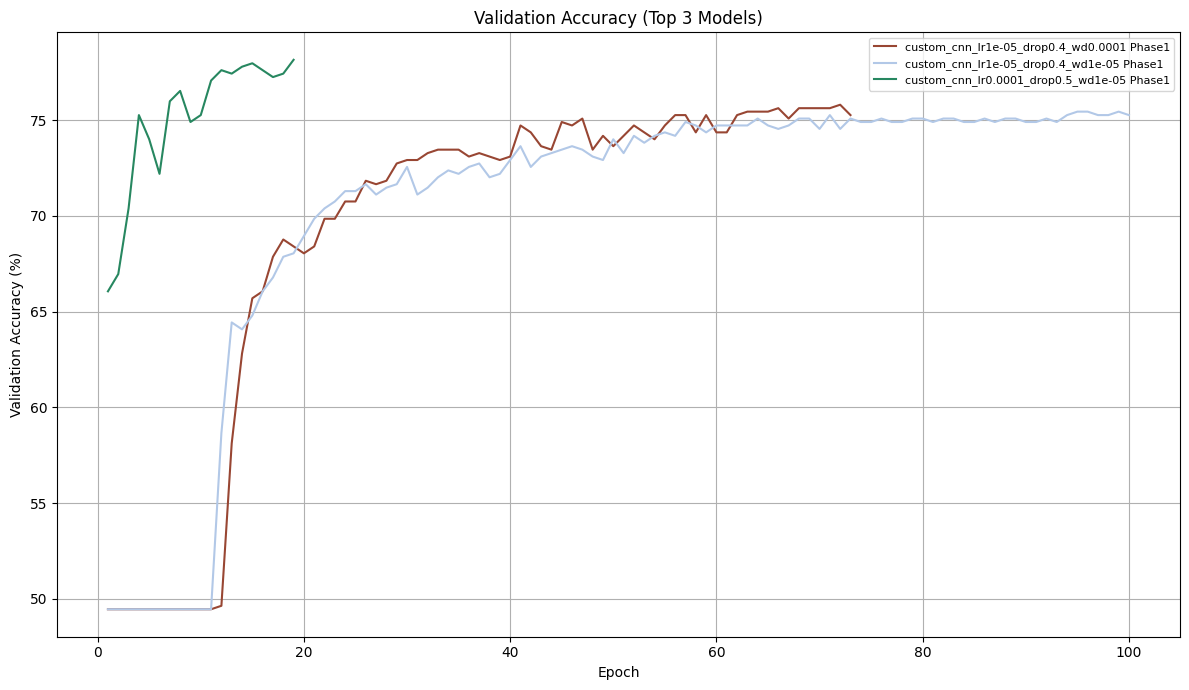

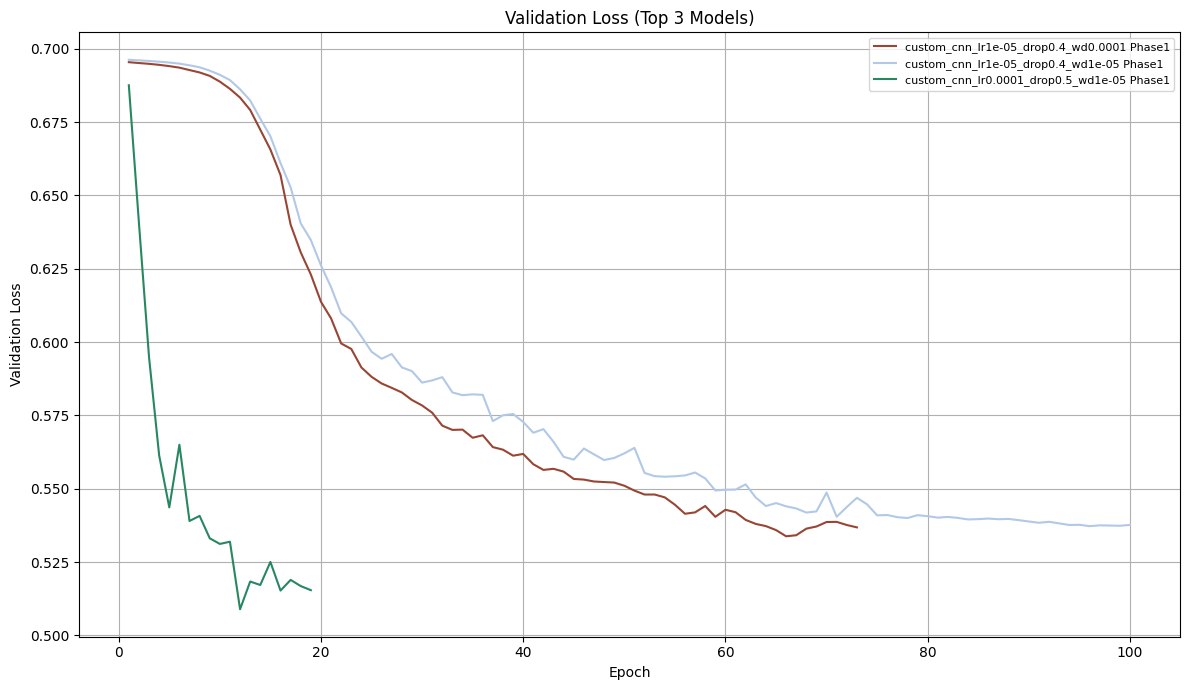

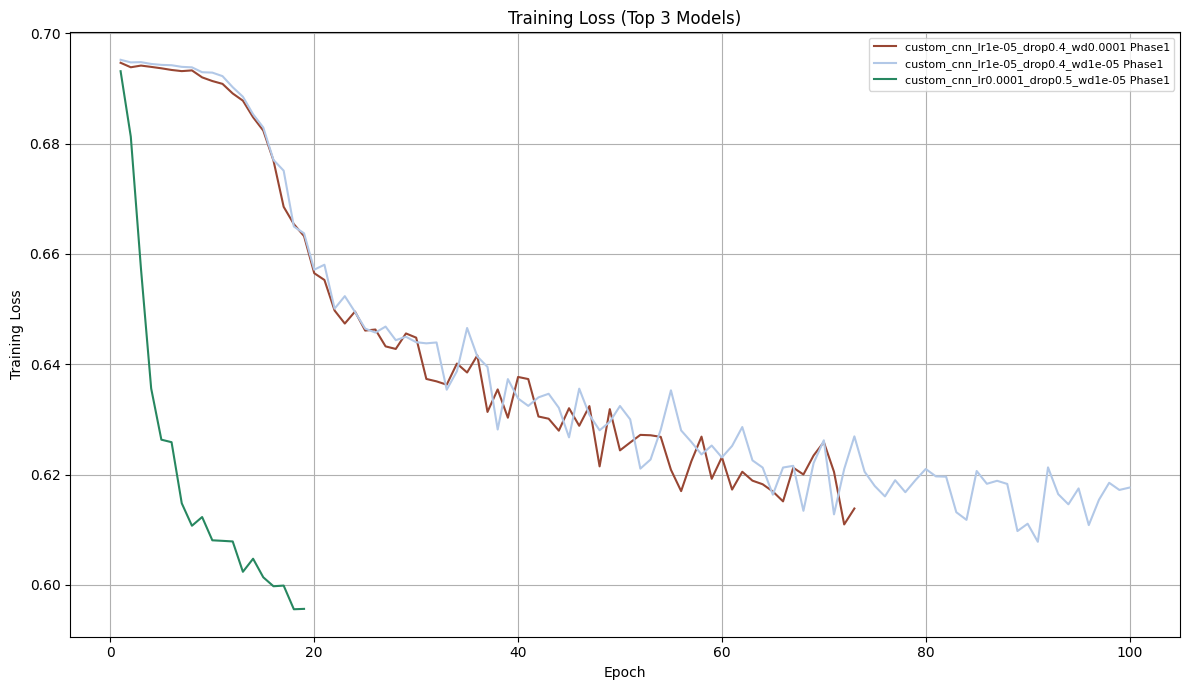

 Top 3 models details for custom_cnn


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
1  custom_cnn        0.00001      0.4        0.0001       76.258993   

   Last Val Acc (Phase1)  
1              75.270758

🔀 Using 2 GPU

Classification Report for model: custom_cnn (1)
              precision    recall  f1-score   support

      Normal     0.7692    0.7527    0.7609       279
      Cancer     0.7562    0.7726    0.7643       277

    accuracy                         0.7626       556
   macro avg     0.7627    0.7626    0.7626       556
weighted avg     0.7627    0.7626    0.7626       556



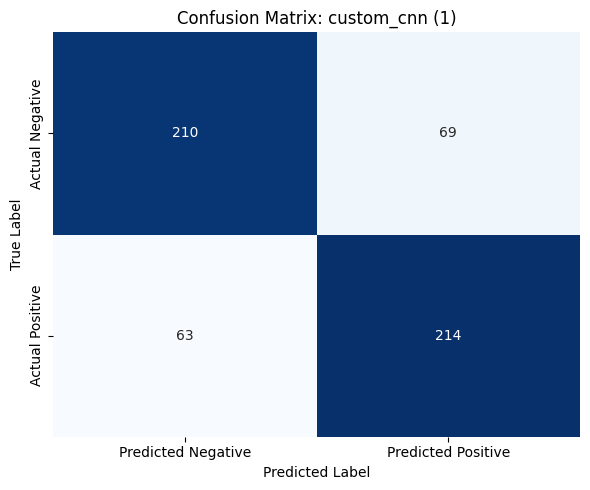

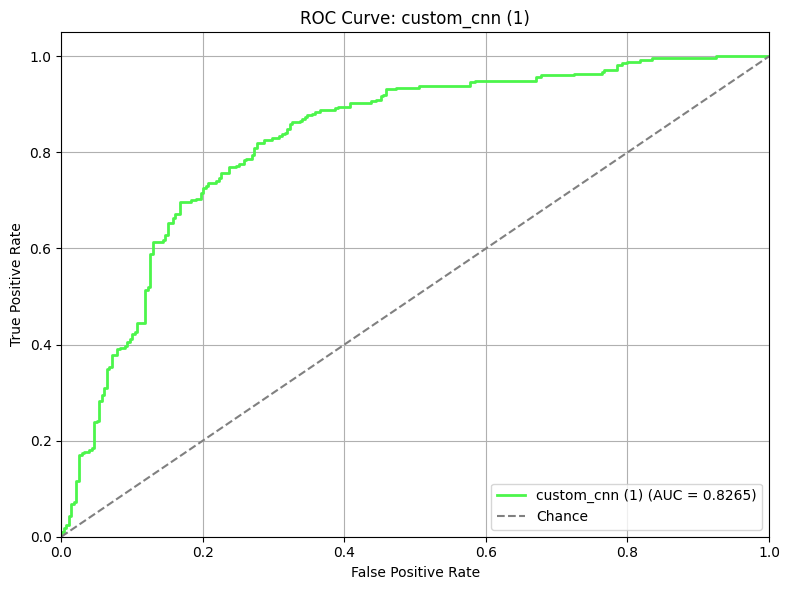

--------------------------------------------------------------------------------


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
2  custom_cnn        0.00001      0.4       0.00001       76.079137   

   Last Val Acc (Phase1)  
2              75.270758

🔀 Using 2 GPU

Classification Report for model: custom_cnn (2)
              precision    recall  f1-score   support

      Normal     0.7517    0.7814    0.7663       279
      Cancer     0.7707    0.7401    0.7551       277

    accuracy                         0.7608       556
   macro avg     0.7612    0.7607    0.7607       556
weighted avg     0.7612    0.7608    0.7607       556



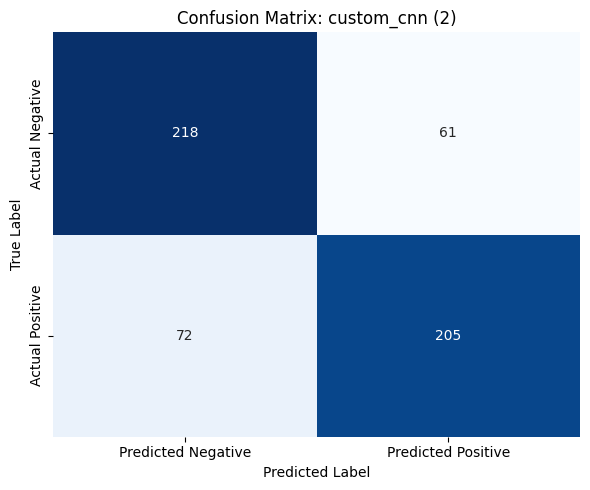

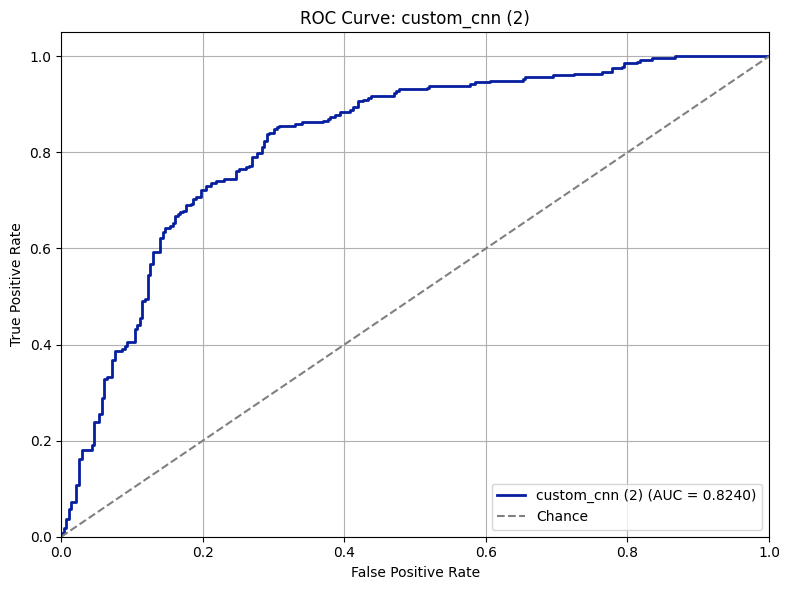

--------------------------------------------------------------------------------


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
3  custom_cnn         0.0001      0.5       0.00001       76.079137   

   Last Val Acc (Phase1)  
3              78.158845

🔀 Using 2 GPU

Classification Report for model: custom_cnn (3)
              precision    recall  f1-score   support

      Normal     0.7724    0.7419    0.7569       279
      Cancer     0.7500    0.7798    0.7646       277

    accuracy                         0.7608       556
   macro avg     0.7612    0.7609    0.7607       556
weighted avg     0.7612    0.7608    0.7607       556



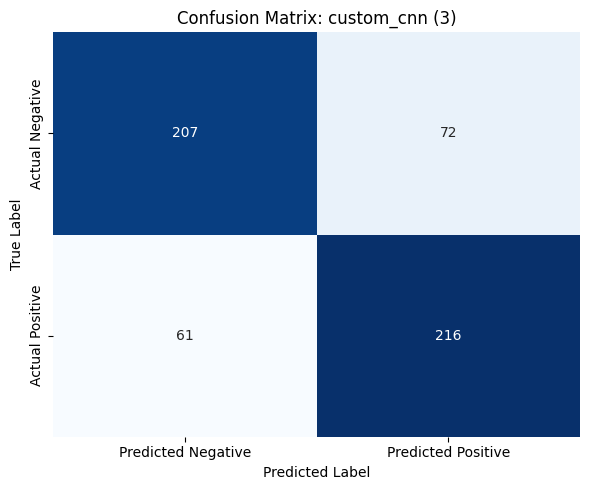

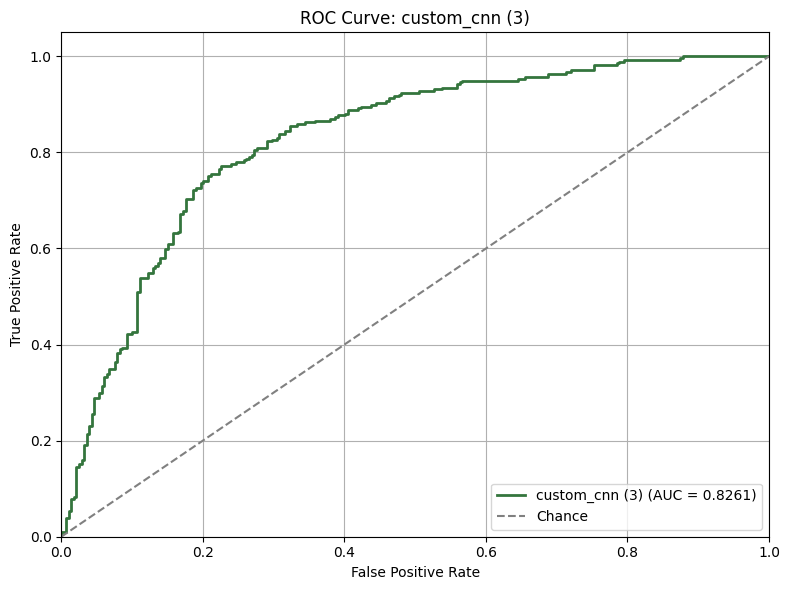

--------------------------------------------------------------------------------


In [41]:
# Provide details summary of the top 3 models
# Plot validation accuracy, validation loss and training loss graphs for the top 3 models
top3_CCNN_graph_summary=plot_graphs_va_vl_tl(customcnn_metrics)
print(" Top 3 models details for custom_cnn")

# Generate summary for the top 3 models, containing the model details, evaluation metrics, confusion matrix and ROC and AUC
customcnn_top3_summary=generate_top3_summary(
    df=customcnn_df,
    filenames=customcnn_filenames,
    model_builder_func=build_cnn_model,
    device_model_setup=device_model_setup,
    weight_directory=customcnn_metrics_dir,
    test_loader=test_loader)


In [42]:
# The table below summarizes the test-set classification performance of the top 3 Custom CNN models. Metrics are provided for both cancer and normal classes.

# Display training and validation summary of the top 3 Custom CNN models based on validation performance
display_top_cnn_summary_table(top3_CCNN_graph_summary, customcnn_df)

# Display detailed classification metrics for the top 3 selected Custom CNN models on the test set
display_classification_summary(customcnn_top3_summary, customcnn_df)



Top 3 custom_cnn Models Summary



Summary Table of Metrics for All Evaluated Models:


After evaluating top three custom CNN models based on final test accuracy and evaluation metrics (precision, recall, F1-score, and AUC), further analysis was conducted on their training dynamics. \
custom_cnn (1) with hyperparameters (learning rate: 0.00001, dropout: 0.4, weight decay: 0.0001)
was selected because:
1. Model exhibited stable trends in validation accuracy and loss over 73 epochs, indicating good convergence.
2. The model reached a final test accuracy of 76.26% and an AUC of 0.8265, with balanced performance across cancer and normal classes.
3. The model completed training efficiently without premature stopping (as seen in the third-best model), and without excessively long training (as in the second model), suggesting optimal convergence without underfitting or overfitting.

#### **b. Efficientnet**

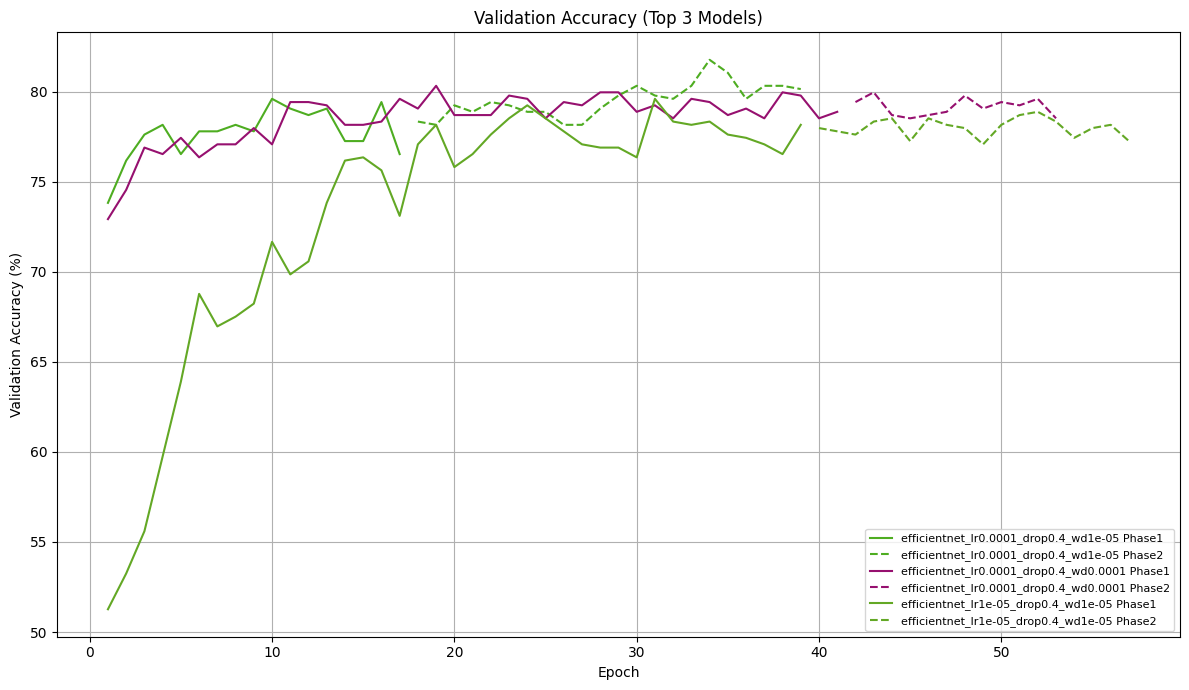

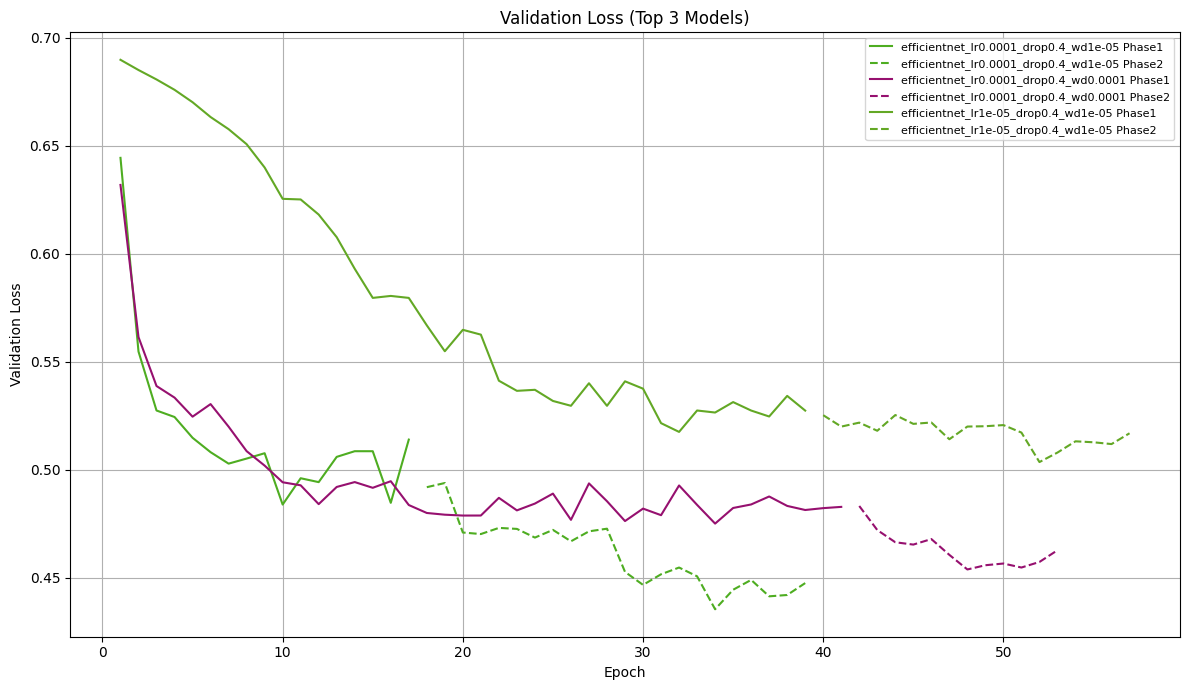

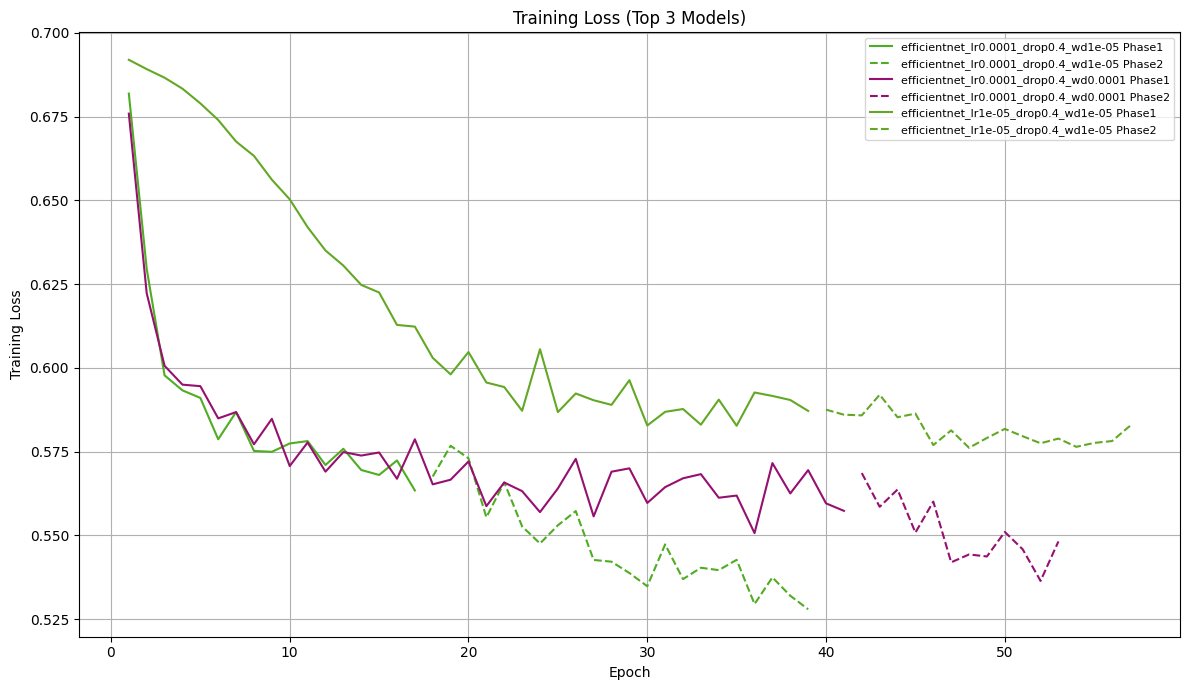

 Top 3 models details for Efficientnet


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
1  efficientnet         0.0001      0.4       0.00001       81.654676   

   Last Val Acc (Phase2)  
1              80.144404

🔀 Using 2 GPU

Classification Report for model: efficientnet (1)
              precision    recall  f1-score   support

      Normal     0.8172    0.8172    0.8172       279
      Cancer     0.8159    0.8159    0.8159       277

    accuracy                         0.8165       556
   macro avg     0.8165    0.8165    0.8165       556
weighted avg     0.8165    0.8165    0.8165       556



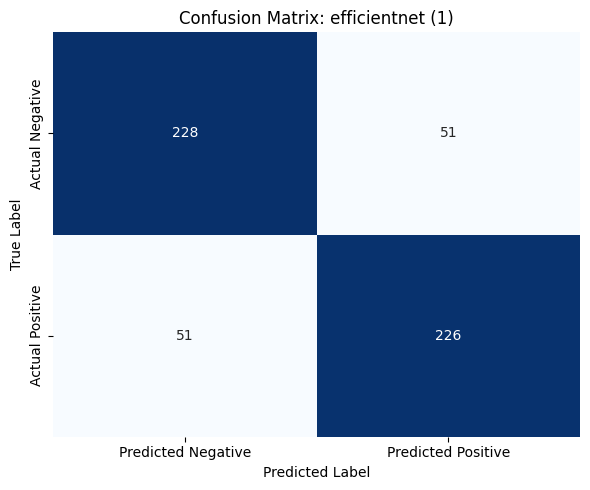

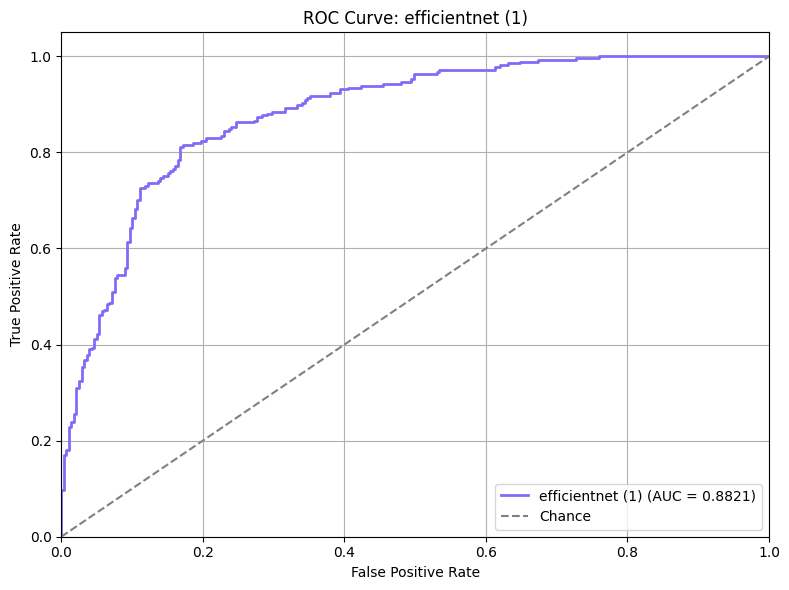

--------------------------------------------------------------------------------


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
2  efficientnet         0.0001      0.4        0.0001       81.294964   

   Last Val Acc (Phase2)  
2              78.519856

🔀 Using 2 GPU

Classification Report for model: efficientnet (2)
              precision    recall  f1-score   support

      Normal     0.8229    0.7993    0.8109       279
      Cancer     0.8035    0.8267    0.8149       277

    accuracy                         0.8129       556
   macro avg     0.8132    0.8130    0.8129       556
weighted avg     0.8132    0.8129    0.8129       556



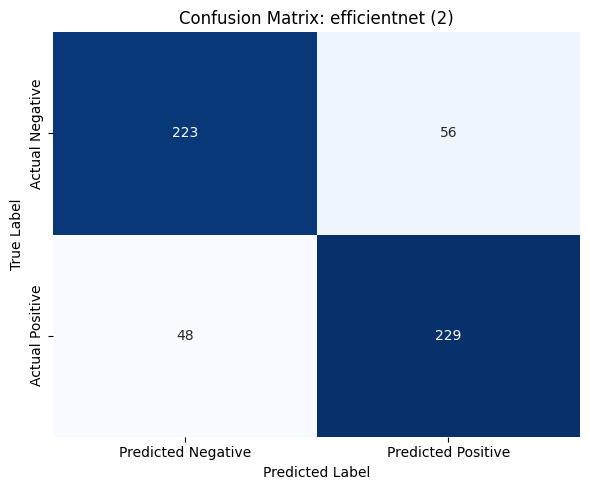

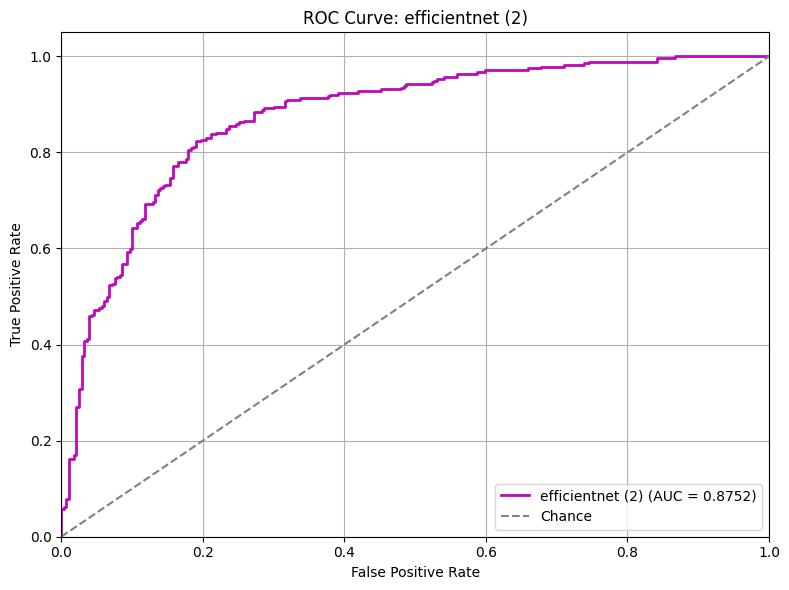

--------------------------------------------------------------------------------


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
3  efficientnet        0.00001      0.4       0.00001       80.935252   

   Last Val Acc (Phase2)  
3              77.256318

🔀 Using 2 GPU

Classification Report for model: efficientnet (3)
              precision    recall  f1-score   support

      Normal     0.8502    0.7527    0.7985       279
      Cancer     0.7767    0.8664    0.8191       277

    accuracy                         0.8094       556
   macro avg     0.8135    0.8096    0.8088       556
weighted avg     0.8136    0.8094    0.8088       556



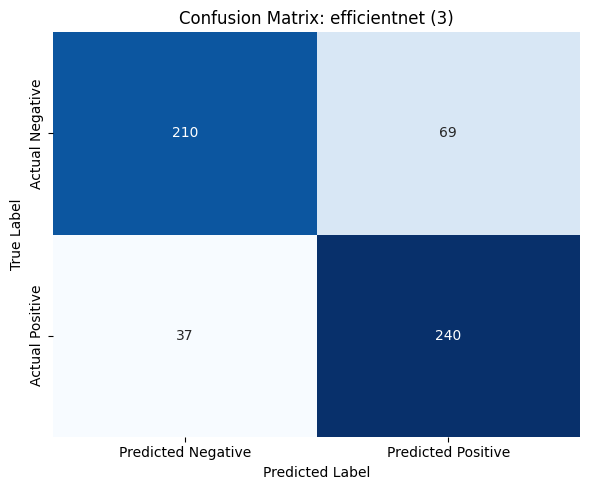

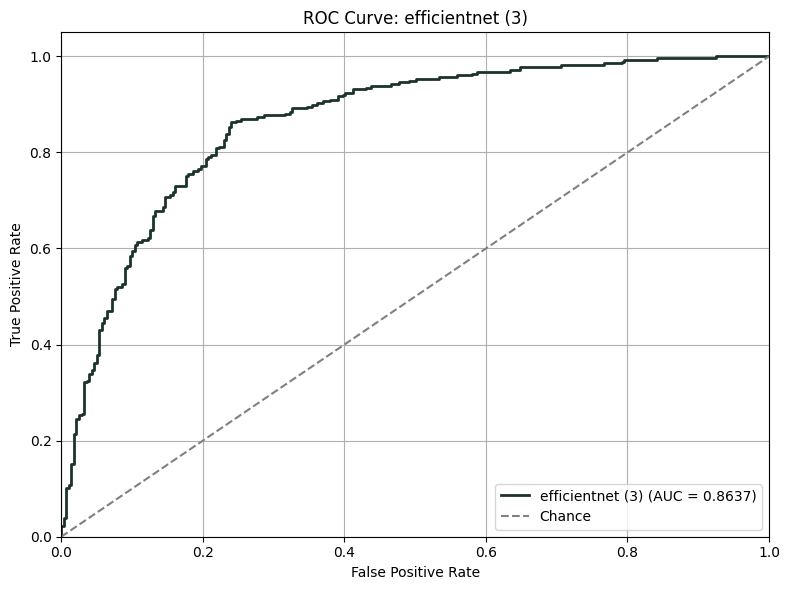

--------------------------------------------------------------------------------


In [43]:
# Plot the graphs for the top 3 models
top3_Efficientnet_graph_summary=plot_graphs_va_vl_tl(efficientnet_metrics)
print(" Top 3 models details for Efficientnet")

# Generate summary for the top 3 models, containing the model details, evaluation metrics, confusion matrix and ROC and AUC
efficientnet_top3_summary=generate_top3_summary(
    df=efficientnet_df,
    filenames=efficientnet_filenames,
    model_builder_func=build_efficientnet,
    device_model_setup=device_model_setup,
    weight_directory=efficientnet_metrics_dir,
    test_loader=test_loader)



In [44]:
# Display training and validation summary of the top 3 Efficientnet models based on validation performance
display_top_cnn_summary_table(top3_Efficientnet_graph_summary, efficientnet_df)

# Display detailed classification metrics for the top 3 selected Efficientnet models on the test set
display_classification_summary(efficientnet_top3_summary, efficientnet_df)


Top 3 efficientnet Models Summary



Summary Table of Metrics for All Evaluated Models:


After evaluating top three fine-tuned EfficientNet models, the model with hyperparameters(learning rate: 0.0001, dropout: 0.4, weight decay: 0.00001) was selected due to: 
1. Highest Test Accuracy: It achieved the best test accuracy of 81.65%, slightly outperforming the second model (81.29%) and third model (80.94%).
2. Consistent Weighted Performance: It recorded the highest and most balanced weighted F1-score (0.8165), precision, and recall,indicating most consistent and reliable overall classification performance.
3. Best AUC: It achieved the highest AUC at 0.8821, surpassing the second (0.8785) and third (0.8750) models.
4. Efficient Convergence: It converged in 39 epochs, approximately 32% faster than the third (57 epochs) and faster than the second (53 epochs), reducing training time while training loss graph converged smoothly.


#### **c. ViT**

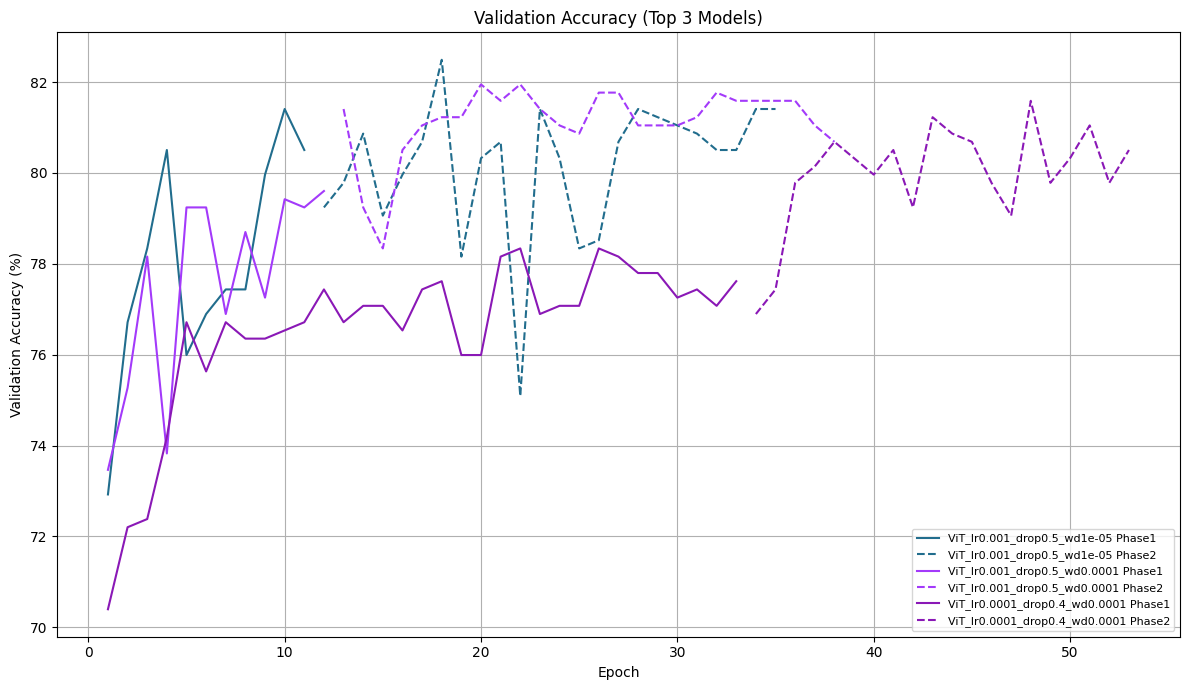

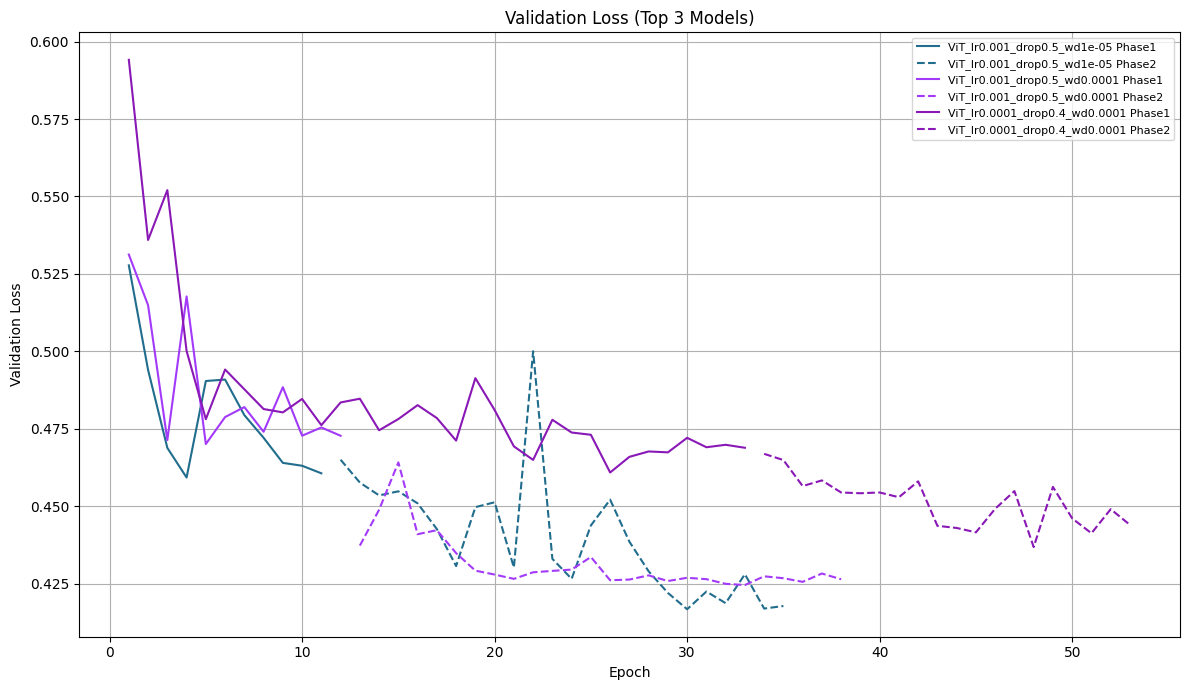

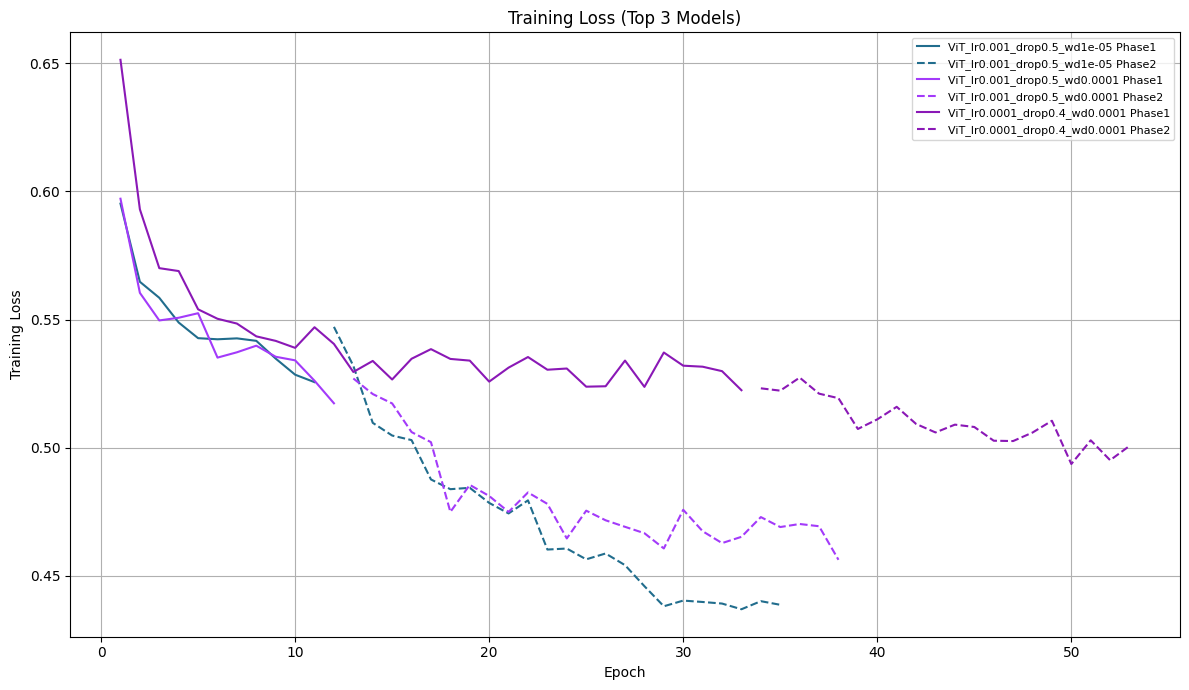

 Top 3 models details for ViT


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
1   ViT          0.001      0.5       0.00001       83.633094   

   Last Val Acc (Phase2)  
1              81.407942

🔀 Using 2 GPU

Classification Report for model: ViT (1)
              precision    recall  f1-score   support

      Normal     0.8760    0.7849    0.8280       279
      Cancer     0.8039    0.8881    0.8439       277

    accuracy                         0.8363       556
   macro avg     0.8400    0.8365    0.8359       556
weighted avg     0.8401    0.8363    0.8359       556



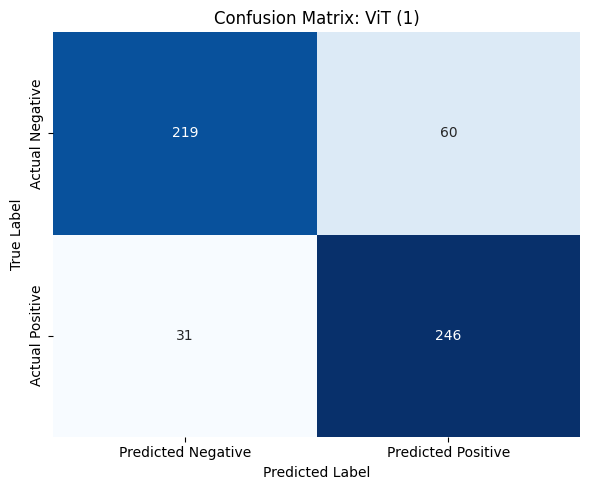

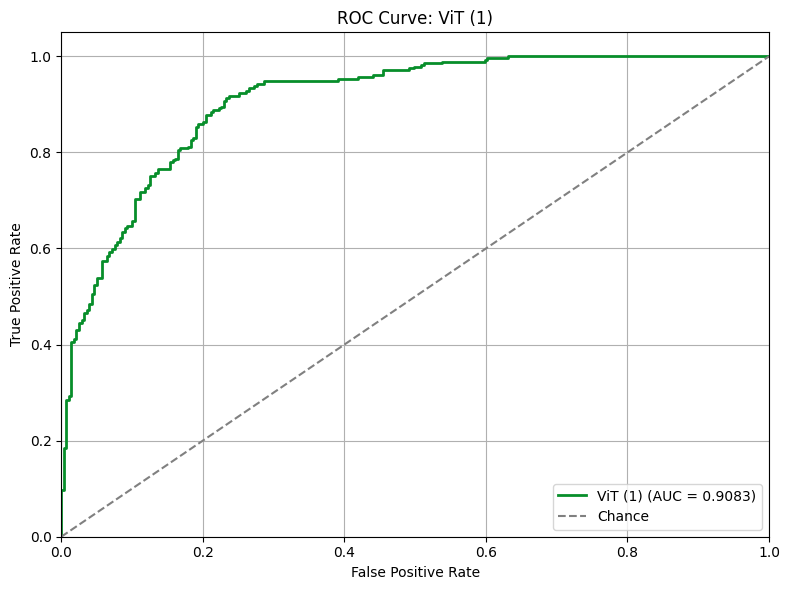

--------------------------------------------------------------------------------


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
2   ViT          0.001      0.5        0.0001       82.913669   

   Last Val Acc (Phase2)  
2              80.685921

🔀 Using 2 GPU

Classification Report for model: ViT (2)
              precision    recall  f1-score   support

      Normal     0.8740    0.7706    0.8190       279
      Cancer     0.7935    0.8881    0.8382       277

    accuracy                         0.8291       556
   macro avg     0.8338    0.8293    0.8286       556
weighted avg     0.8339    0.8291    0.8286       556



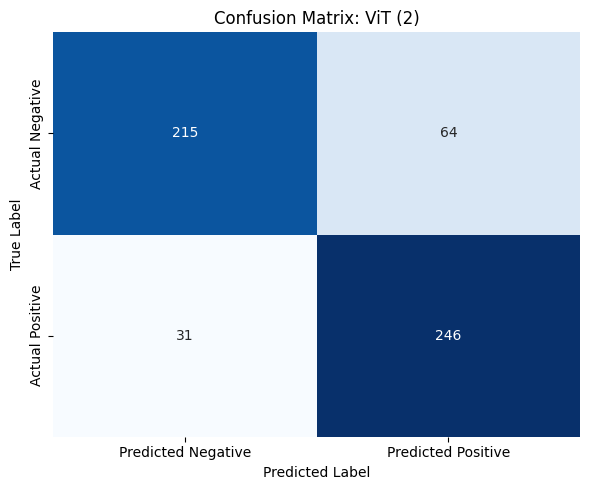

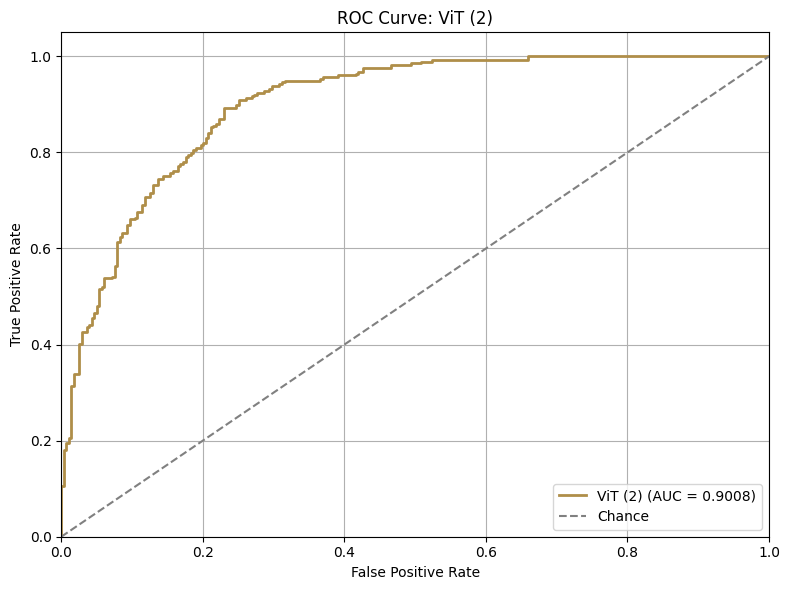

--------------------------------------------------------------------------------


Model  Learning Rate  Dropout  Weight Decay  Final Accuracy  \
3   ViT         0.0001      0.4        0.0001       82.553957   

   Last Val Acc (Phase2)  
3              80.505415

🔀 Using 2 GPU

Classification Report for model: ViT (3)
              precision    recall  f1-score   support

      Normal     0.8889    0.7455    0.8109       279
      Cancer     0.7795    0.9061    0.8381       277

    accuracy                         0.8255       556
   macro avg     0.8342    0.8258    0.8245       556
weighted avg     0.8344    0.8255    0.8244       556



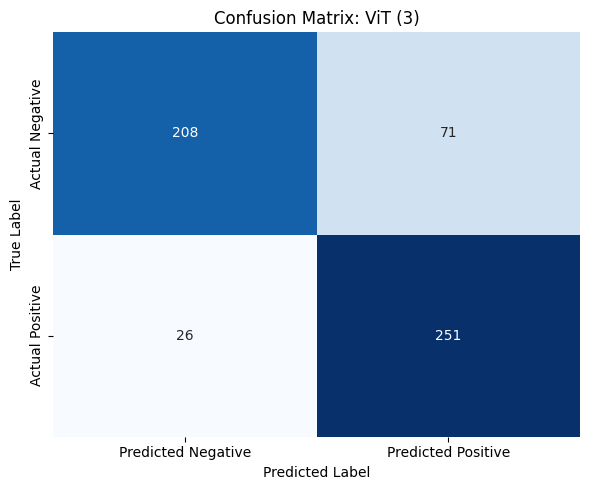

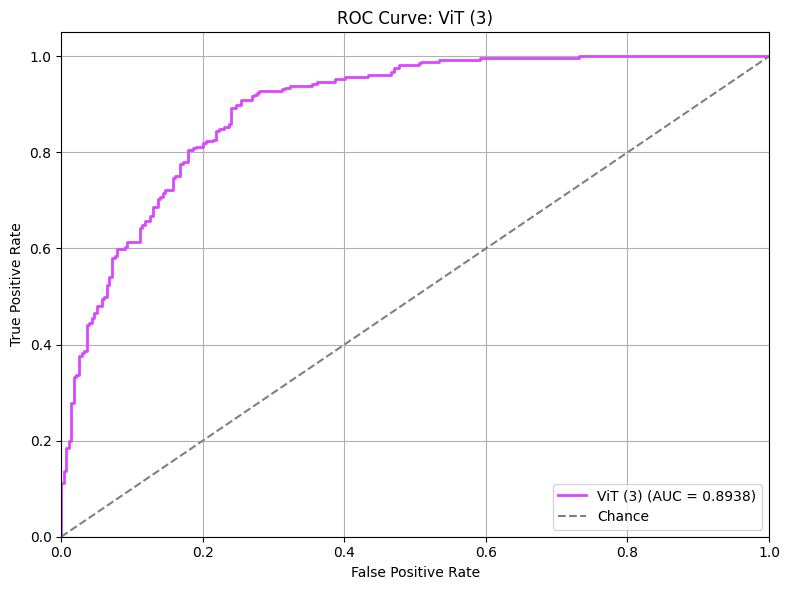

--------------------------------------------------------------------------------


In [45]:

# Plot the graphs for the top 3 models
top3_vit_graph_summary=plot_graphs_va_vl_tl(vit_metrics)
print(" Top 3 models details for ViT")

# Generate summary for the top 3 models, containing the model details, evaluation metrics, confusion matrix and ROC and AUC
vit_top3_summary=generate_top3_summary(
    df=vit_df,
    filenames=vit_filenames,
    model_builder_func=build_vit,
    device_model_setup=device_model_setup,
    weight_directory=vit_metrics_dir,
    test_loader=test_loader)


In [46]:
# The specific model used is vit-base-patch16-224, pretrained by Google
# Display training and validation summary of the top 3 vit models based on validation performance
display_top_cnn_summary_table(top3_vit_graph_summary, vit_df)
# Display detailed classification metrics for the top 3 selected vit models on the test set
display_classification_summary(vit_top3_summary, vit_df)


Top 3 ViT Models Summary



Summary Table of Metrics for All Evaluated Models:


After evaluating top three fine-tuned ViT models, the model with hyperparameters(learning rate: 0.001, dropout: 0.5, weight decay: 0.00001) was selected due to:
1. Highest Test Accuracy: Model achieved an overall accuracy of 83.63%, slightly outperforming the second model (82.91%) and third model (82.55%).
2. Best Weighted Performance: Among all model, it achieved the best weighted F1-score (0.8359), Precision (0.8401) and recall (0.8363).
3. Best Area Under the ROC Curce (AUC): Model achieved highest value, scoring 0.9083, outperforming second (0.9008) and third model (0.8938) respectively.
4. Fastest Training Convergence: Model completed both classifier head training and fine-tuning in just 35 epoch, fastest among the rest while training loss graph converged smoothly, indicating not underfitting nor overfitting.


## **d. Final Model Comparison and Selection**

### **1. Classification Reports of Models**

In [47]:
# Generate classification report for all models
print("Classification Report for model: Custom-CNN")
print(efficientnet_top3_summary[0]["classification_report"])

print("Classification Report for model: Efficientnet")
print(customcnn_top3_summary[0]["classification_report"])

print("Classification Report for model: ViT")
print(vit_top3_summary[0]["classification_report"]) 


Classification Report for model: Custom-CNN
              precision    recall  f1-score   support

      Normal     0.8172    0.8172    0.8172       279
      Cancer     0.8159    0.8159    0.8159       277

    accuracy                         0.8165       556
   macro avg     0.8165    0.8165    0.8165       556
weighted avg     0.8165    0.8165    0.8165       556

Classification Report for model: Efficientnet
              precision    recall  f1-score   support

      Normal     0.7692    0.7527    0.7609       279
      Cancer     0.7562    0.7726    0.7643       277

    accuracy                         0.7626       556
   macro avg     0.7627    0.7626    0.7626       556
weighted avg     0.7627    0.7626    0.7626       556

Classification Report for model: ViT
              precision    recall  f1-score   support

      Normal     0.8760    0.7849    0.8280       279
      Cancer     0.8039    0.8881    0.8439       277

    accuracy                         0.8363       556
 

### **2. ROC Curves and AUC Comparison**

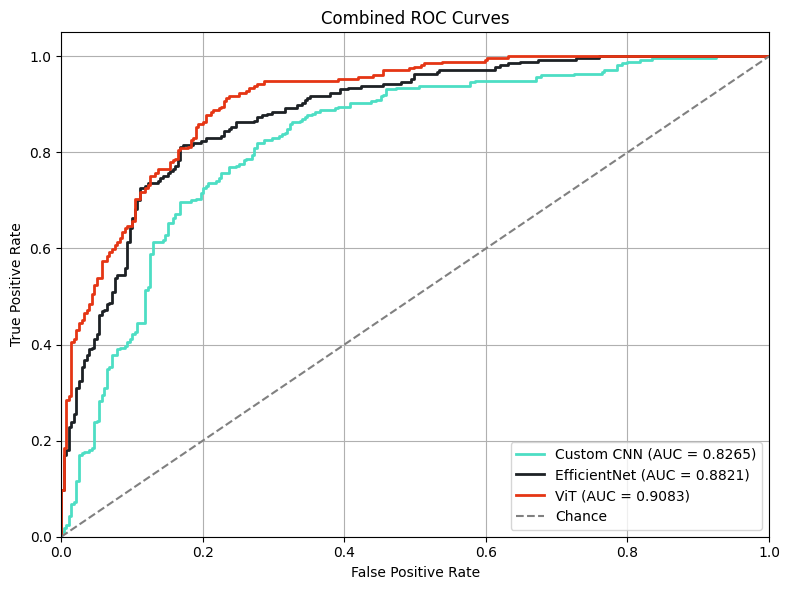

In [48]:
#  Plot the combined ROC curves for all models available
def plot_combined_roc_auc(models_data):
    
    plt.figure(figsize=(8, 6))

    for model_name, y_true, y_prob in models_data:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        color = get_random_color()
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})", color=color)

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Combined ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot a combined ROC AUC curves, compiling all best
plot_combined_roc_auc([
    ("Custom CNN", customcnn_top3_summary[0]["labels"], customcnn_top3_summary[0]["probs"]),
    ("EfficientNet",efficientnet_top3_summary[0]["labels"], efficientnet_top3_summary[0]["probs"]),
    ("ViT", vit_top3_summary[0]["labels"], vit_top3_summary[0]["probs"]),
])

### ROC and AUC summary

This section presents the ROC curves and AUC scores for all evaluated models, plotted together for direct comparison. ROC and AUC were chosen as evaluation metrics because they consider all decision thresholds, providing a consistent basis for model comparison (Li, 2024).

#### AUC Scores:
- **ViT:0.9083**
- **Efficientnet:0.8821**
- **CustomCNN:0.8265**

Among the three model, ViT exhibit the strongest accuracy, having its curves closer towards the top-left corner of the graph, as compared to Efficienet and CustomCNN.

### **3. Confusion Matrix**

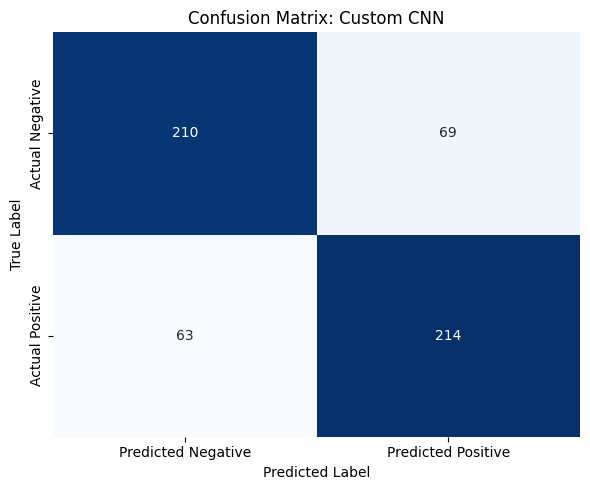

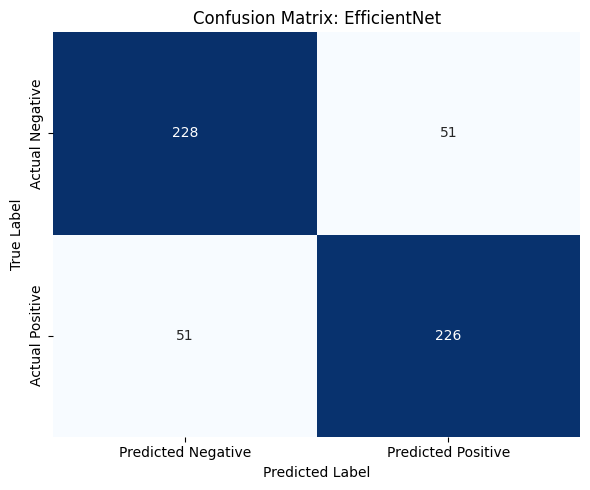

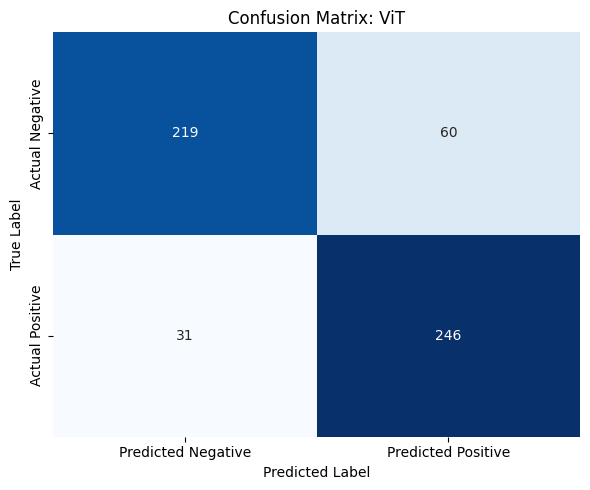

In [50]:
# Plot confusion Matrix for all models
plot_confusion_matrix(customcnn_top3_summary[0]["labels"], customcnn_top3_summary[0]["preds"], model_name="Custom CNN")
plot_confusion_matrix(efficientnet_top3_summary[0]["labels"], efficientnet_top3_summary[0]["preds"], model_name="EfficientNet")
plot_confusion_matrix(vit_top3_summary[0]["labels"], vit_top3_summary[0]["preds"], model_name="ViT")


### **4. Misclassified Case Analysis**

To help in understanding the model behavior examples of misclassified images (false positives and false negatives) were extracted from the test set for each top-performing model. Although not part of core evaluation metrics, this analysis helps identify patterns in errors, offering valuable insights for researchers to explore model weaknesses and potential improvements in future work.

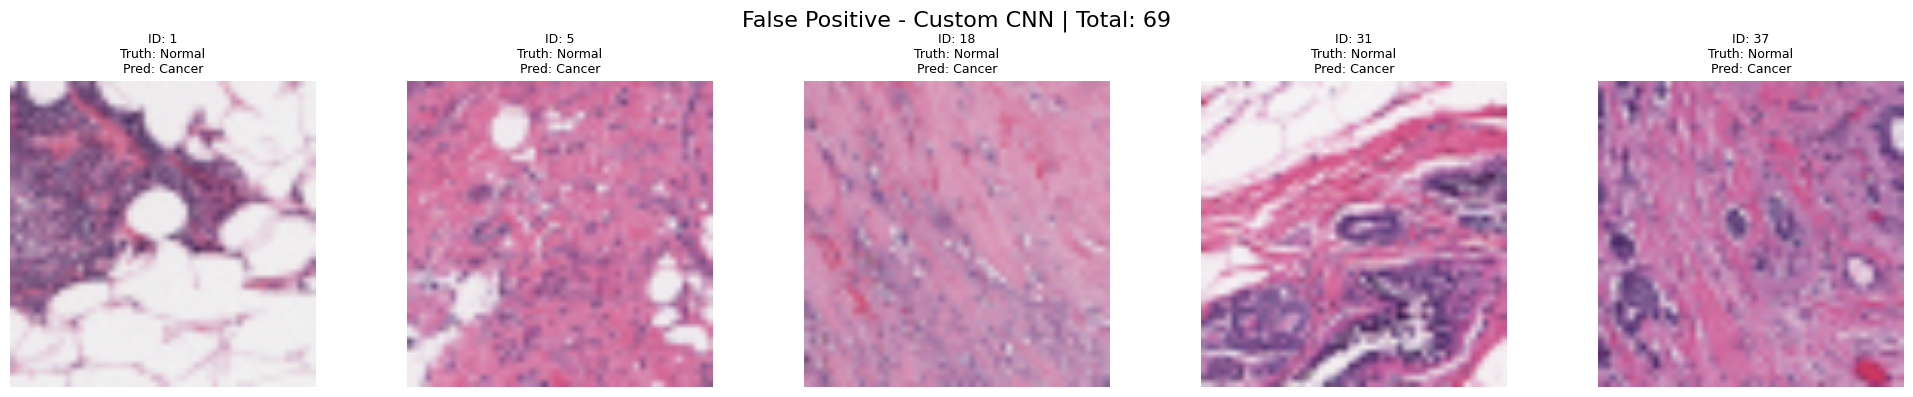

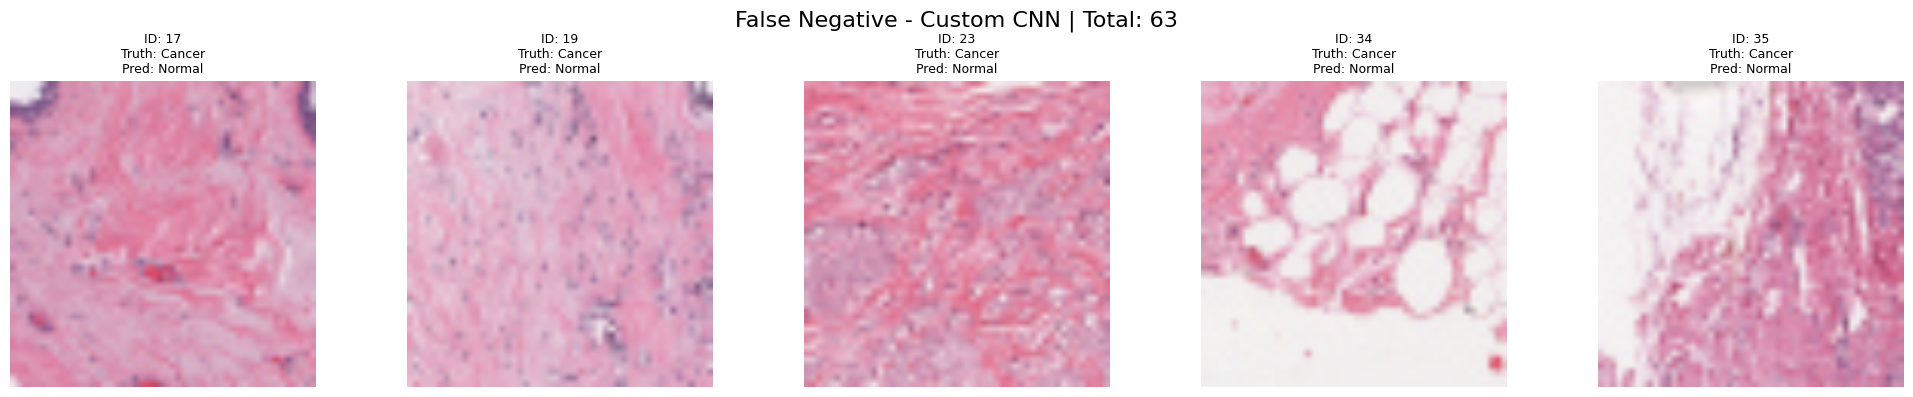

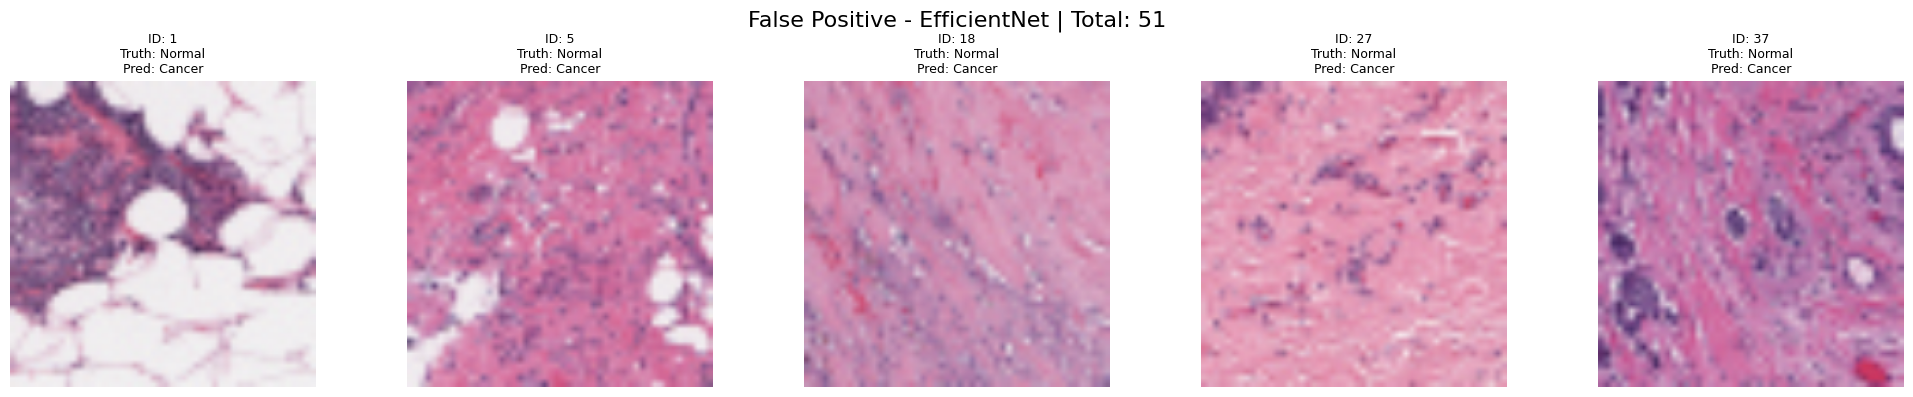

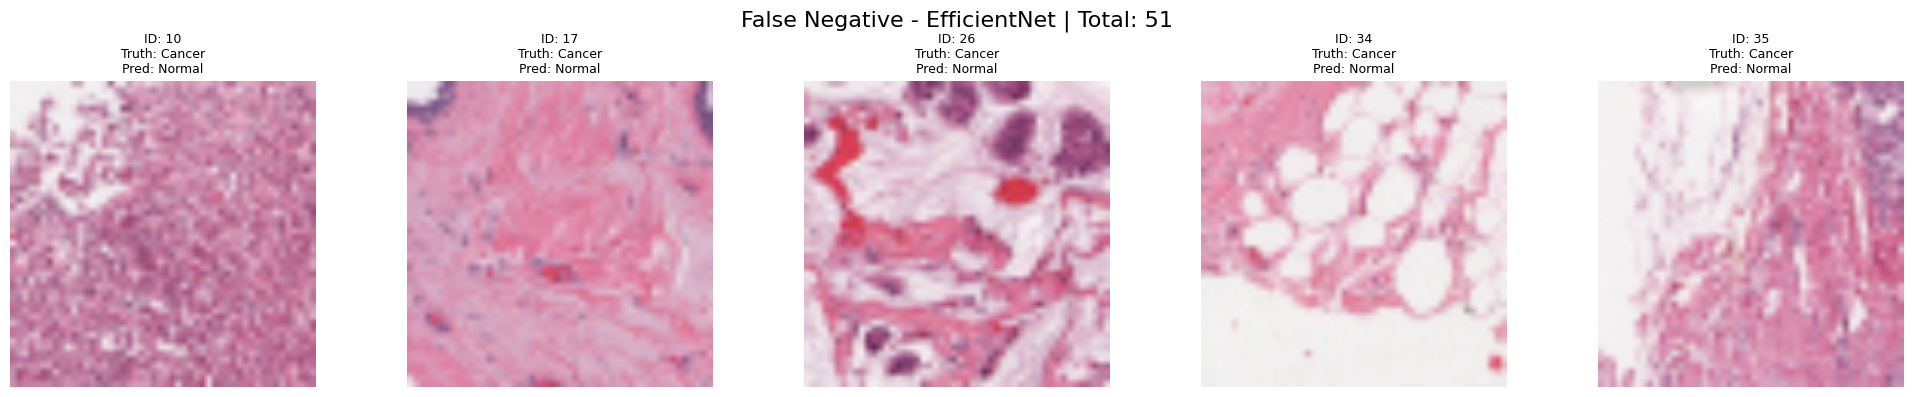

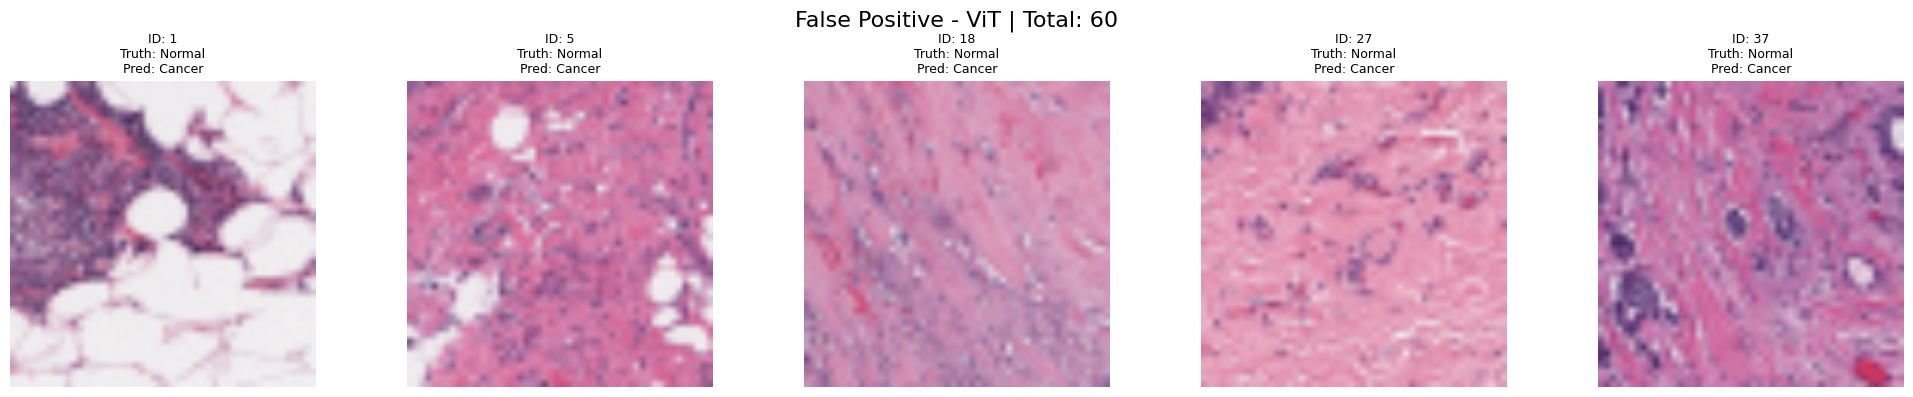

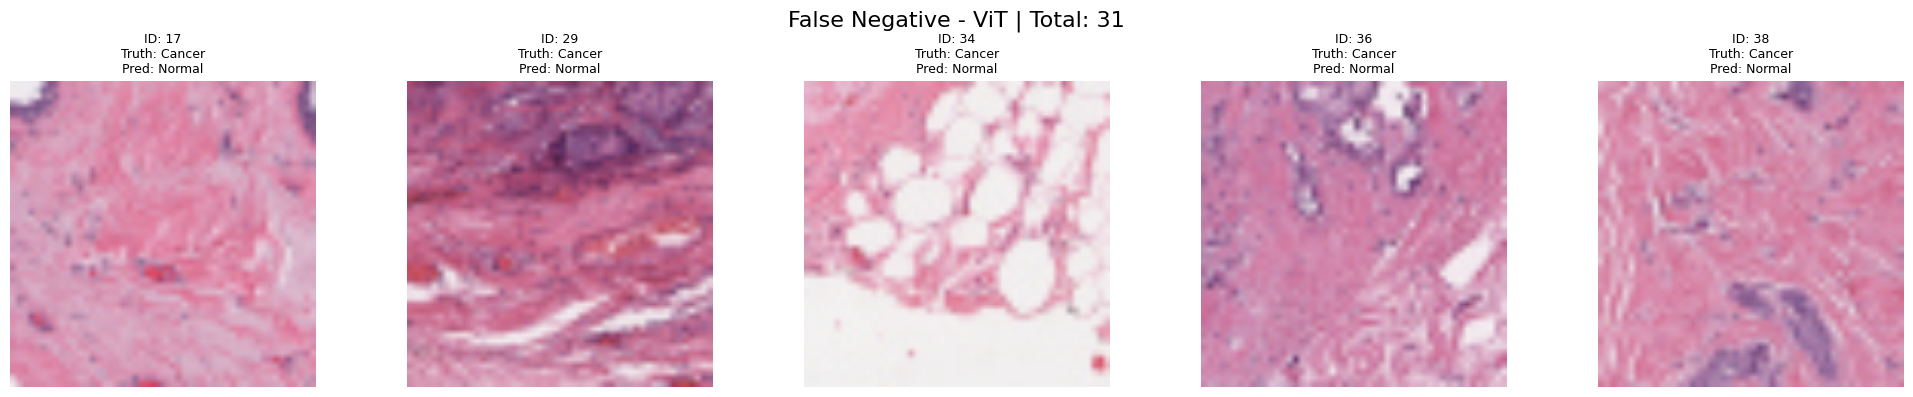

In [102]:
# Access model and device from the summary 
# Then showcase sample of misclassified images (false positive and flase negative) for each model

# Custom CNN 
cnn_model = customcnn_top3_summary[0]["model"]
cnn_device = customcnn_top3_summary[0]["device"]

show_misclassified_images_from_model(
    model=cnn_model,
    device=cnn_device,
    test_loader=test_loader,
    model_name="Custom CNN",
    max_per_type=5
)

# EfficientNet
eff_model = efficientnet_top3_summary[0]["model"]
eff_device = efficientnet_top3_summary[0]["device"]

show_misclassified_images_from_model(
    model=eff_model,
    device=eff_device,
    test_loader=test_loader,
    model_name="EfficientNet",
    max_per_type=5
)

# ViT
vit_model = vit_top3_summary[0]["model"]
vit_device = vit_top3_summary[0]["device"]

show_misclassified_images_from_model(
    vit_model,
    vit_device,
    test_loader,
    model_name="ViT",
    max_per_type=5
)


### **5. Learning Curves of Selected Architectures**

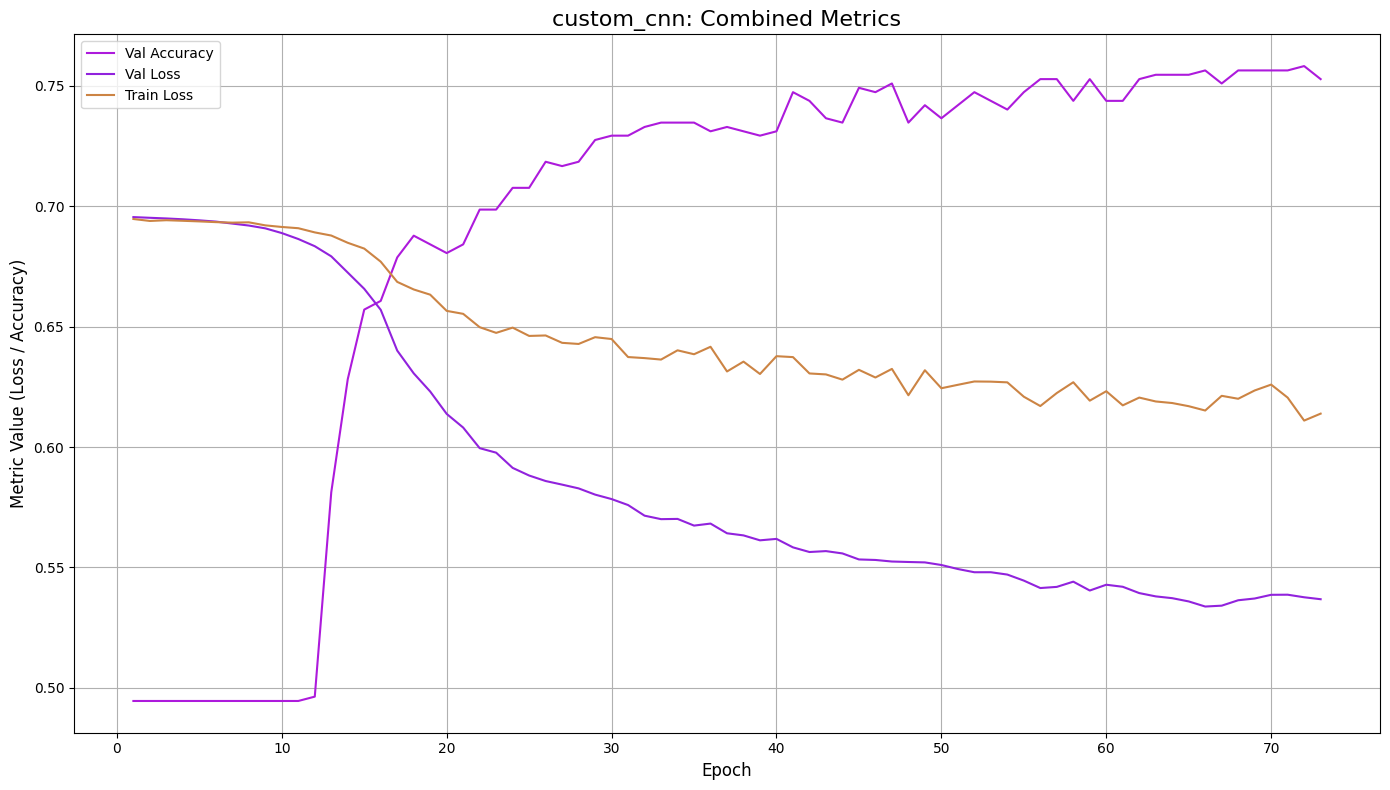

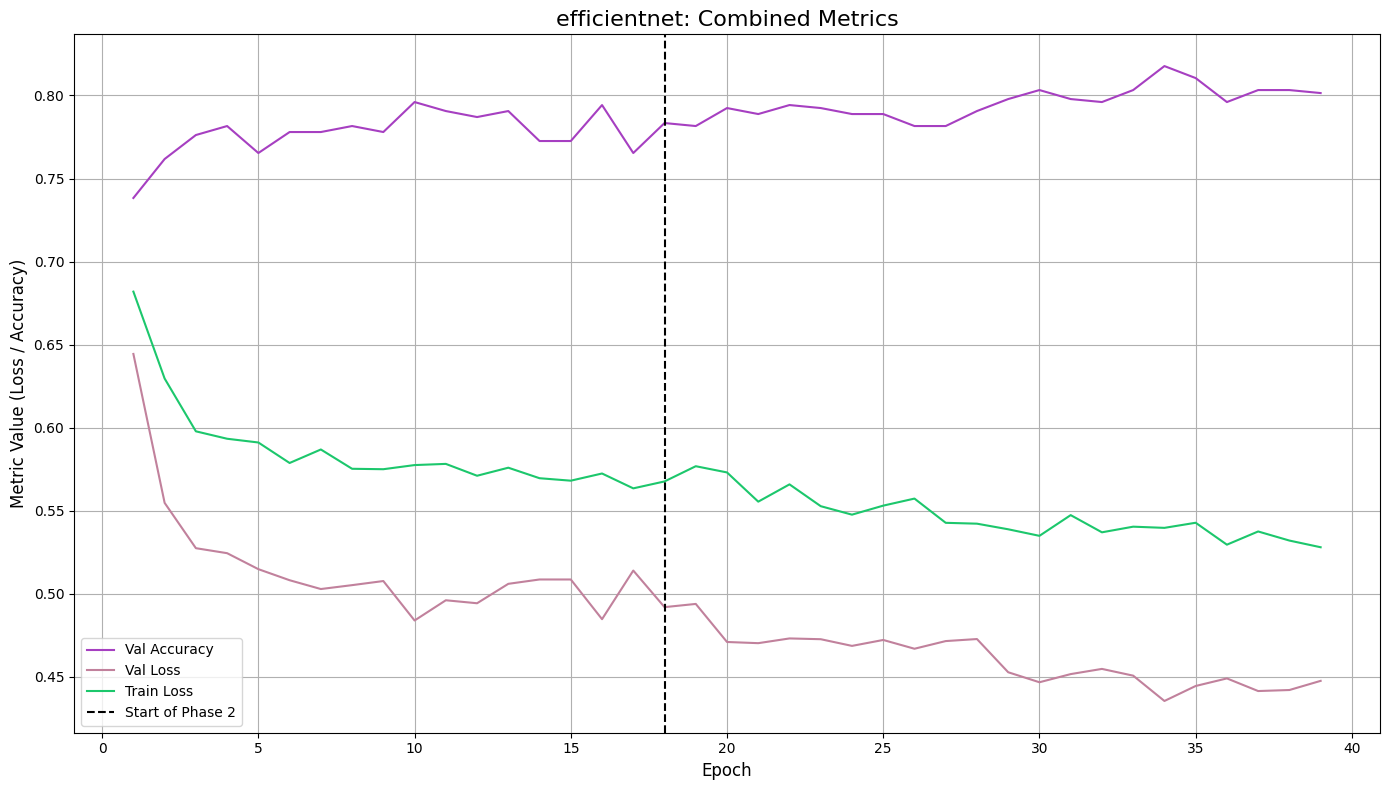

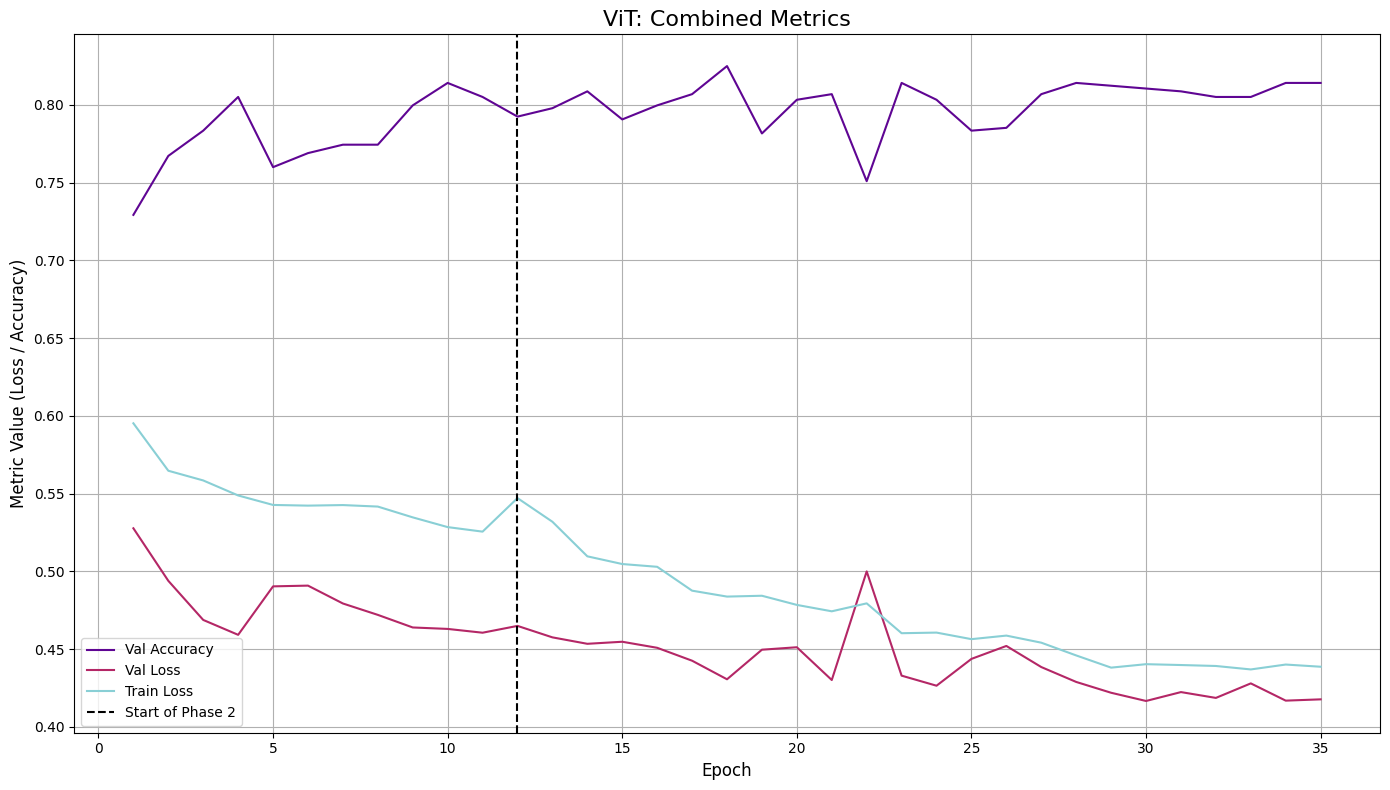

In [101]:
# Plot model
# Custom CNN Training Curve
plot_single_model(customcnn_metrics_dir, customcnn_filenames[0])

# EfficientNetB0 Training Curve
plot_single_model(efficientnet_metrics_dir, efficientnet_filenames[0])

# ViT Training Curve
plot_single_model(vit_metrics_dir, vit_filenames[0])

### **6. Best Model Hyperparameter Overview**


In [112]:
best_graph_report = [
    top3_CCNN_graph_summary.iloc[0],
    top3_Efficientnet_graph_summary.iloc[0],
    top3_vit_graph_summary.iloc[0]
]

all_best_reports = [
    customcnn_top3_summary[0],
    efficientnet_top3_summary[0],
    vit_top3_summary[0]
]

all_best_df = pd.concat([
    customcnn_df.iloc[[0]].assign(Model="custom_cnn"),
    efficientnet_df.iloc[[0]].assign(Model="efficientnet"),
    vit_df.iloc[[0]].assign(Model="vit")
], ignore_index=True)

# ✅ Convert list of Series to DataFrame
display_top_cnn_summary_table(pd.DataFrame(best_graph_report), all_best_df)
display_classification_summary(all_best_reports, all_best_df)



Top 3 custom_cnn Models Summary



Summary Table of Metrics for All Evaluated Models:


### Final Model Comparison and Selection
To evaluate the best model performance,standard classification metrics were used, AUC, ROC curves and reading from Confusion matrix.


#### Result
* **Best Model**: ViT achieved the highest test performance result across most metrics, achieving test accuracy of 83.63%.
* **Most Balanced Model**: Efficientnet offered a strong balance across all result in the metrics, obtaining balanced weighted F1-score (0.8165), precision, and recall,indicating most consistent and reliable overall classification performance.
* **Lightweight Option**: Custom CNN, achieved lowest performance, yet showed respectable results despite not using pre-trained weights or fine-tuning. Its strength lies in its simplicity and efficiency, making it suitable for low-resource applications.

# **4. Critical Reflection**

#### Strengths
- The success of EfficientNet and ViT is largely due to transfer learning and top-tuning, where only the classifier head is trained initially. This method achieves accuracy comparable to full fine-tuning with significantly lower training time (Paolo Didier Alfano et al., 2024).
- All models performed well within their architecture types, aided by effective hyperparameter tuning, which improved performance and generalization (Justus Akinlolu Ilemobayo et al., 2024).
- Dynamic data augmentation, with varied transforms per epoch, improved generalization—especially for ViT, which needs more data due to lack of inductive bias (Zhang et al., 2024).

#### Limitations
- The dataset size was relatively small, requiring better augmentation method to increase training data.
- Traditional machine learning model was not used for the comparison, limiting the comparison to simpler baselines.
- Pre-trained models were based on ImageNet, which may not align well with clinical image characteristics (Deng et al., 2009).

#### Areas for Improvement
- Future work could use ensemble methods to combine model strengths for better accuracy in medical tasks (Behzad Naderalvojoud & Hernandez-Boussard, 2024).
- Explainable AI techniques (e.g., Grad-CAM, SHAP) would improve transparency and support adoption in safety-critical settings (Kamakshi & Krishnan, 2023).
- Future implementations could benefit from domain-specific pretraining on histopathology datasets, where it can learn based on relevant information (Kerner, 2024).

#### Conclusion
This project evaluated IDC classification using one self-built CNN and two pre-trained models (EfficientNet-B0 and ViT), each adapted with custom classifier heads. Top-tuning, augmentation, and tuning strategies enabled ViT to achieve the highest accuracy, while EfficientNet offered the most balanced performance.

These results highlight the value of transfer learning in medical imaging when paired with the right data strategies. Despite limitations like small dataset size and non-specialized pretraining, the approach proved effective and provides a strong base for future work in explainability and domain adaptation.

# 5. References
- A Ilemobayo, J. et al. (2024) “Hyperparameter Tuning in Machine Learning: A Comprehensive Review,” Journal of Engineering Research and Reports, 26(6), pp. 388–395. Available at: https://doi.org/10.9734/JERR/2024/V26I61188.
- Alfano, P.D. et al. (2024) “Top-tuning: A study on transfer learning for an efficient alternative to fine tuning for image classification with fast kernel methods,” Image and Vision Computing, 142, p. 104894. Available at: https://doi.org/10.1016/J.IMAVIS.2023.104894.
- Deng, J. et al. (2009) “ImageNet: A Large-Scale Hierarchical Image Database,” 2009 IEEE Conference on Computer Vision and Pattern Recognition, CVPR 2009, pp. 248–255. Available at: https://doi.org/10.1109/CVPR.2009.5206848.
- Kerner, T. (2024) “Domain-Specific Pretraining of Language Models: A Comparative Study in the Medical Field.” Available at: https://arxiv.org/pdf/2407.14076v1 (Accessed: May 14, 2025).
- Kamakshi, V. and Krishnan, N.C. (2023) “Explainable Image Classification: The Journey So Far and the Road Ahead,” AI 2023, Vol. 4, Pages 620-651, 4(3), pp. 620–651. Available at: https://doi.org/10.3390/AI4030033.
- Li, J. (2024) “Area under the ROC Curve has the Most Consistent Evaluation for Binary Classification,” PLOS ONE. Edited by H. Qin, 19(12), p. e0316019. Available at: https://doi.org/10.1371/journal.pone.0316019.
- Lin, M., Chen, Q. and Yan, S. (2013) “Network In Network,” 2nd International Conference on Learning Representations, ICLR 2014 - Conference Track Proceedings [Preprint]. Available at: https://arxiv.org/pdf/1312.4400 (Accessed: April 30, 2025).
- Łukasiewicz, S. et al. (2021) “Breast Cancer—Epidemiology, Risk Factors, Classification, Prognostic Markers, and Current Treatment Strategies—An Updated Review,” Cancers, 13(17), p. 4287. Available at: https://doi.org/10.3390/CANCERS13174287.
- Naderalvojoud, B. and Hernandez-Boussard, T. (2024) “Improving machine learning with ensemble learning on observational healthcare data,” AMIA Annual Symposium Proceedings, 2023, p. 521. Available at: https://pmc.ncbi.nlm.nih.gov/articles/PMC10785929/ (Accessed: May 14, 2025).
- O’Shea, K. and Nash, R. (2015) “An Introduction to Convolutional Neural Networks,” International Journal for Research in Applied Science and Engineering Technology, 10(12), pp. 943–947. Available at: https://doi.org/10.22214/ijraset.2022.47789.
- Tan, M. and Le, Q. v. (2019) “EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,” 36th International Conference on Machine Learning, ICML 2019, 2019-June, pp. 10691–10700. Available at: https://arxiv.org/pdf/1905.11946 (Accessed: May 14, 2025).
- Wei, Q. and Dunbrack, R.L. (2013) “The Role of Balanced Training and Testing Data Sets for Binary Classifiers in Bioinformatics,” PLoS ONE, 8(7), p. e67863. Available at: https://doi.org/10.1371/JOURNAL.PONE.0067863.
- Yu, X. et al. (2024) “DynamicAug: Enhancing Transfer Learning Through Dynamic Data Augmentation Strategies Based on Model State,” Neural Processing Letters, 56(3), pp. 1–27. Available at: https://doi.org/10.1007/S11063-024-11626-9/FIGURES/7.
- Zhang, T. et al. (2025) “Depth-Wise Convolutions in Vision Transformers for efficient training on small datasets,” Neurocomputing, 617, p. 128998. Available at: https://doi.org/10.1016/J.NEUCOM.2024.128998.
- Zheng, C. and Sun, D.W. (2008) “Image Segmentation Techniques,” Computer Vision Technology for Food Quality Evaluation, pp. 37–56. Available at: https://doi.org/10.1016/B978-012373642-0.50005-3.

